In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import argparse
import os

from azureml.core.run import Run
from azureml.core import Workspace, Dataset
from tf_agents.environments import tf_py_environment, py_environment, utils
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import EpsilonGreedyPolicy, random_tf_policy, tf_policy, tf_py_policy, py_policy
from tf_agents.policies.q_policy import QPolicy
from tf_agents.policies.boltzmann_policy import BoltzmannPolicy
from tf_agents.trajectories import trajectory, Trajectory, PolicyStep, time_step as ts
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.metrics import tf_metrics
from tf_agents.specs import array_spec
from tf_agents.drivers import dynamic_step_driver
from tf_agents.utils import common
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from helper_functions import *
from environment_functions import *

In [2]:
class DynamicPricingCompetition():
    
    """
    A game object where the agent can interact with and that we can update remotely
    to adjust the current state based on recent observations.
    This class also keeps track of all the steps and rewards that took place for later analysis.
    """
    
    def __init__(self):
        self.selling_period = 1
        self.loadfactor = 0
        self.comp_loadfactor = 0
        self.competitor_has_capacity = 1
        self.price_competitor_t1 = 50
        self.price_competitor_t2 = 50
        self.price_competitor_t3 = 50
        self.price_competitor_t4 = 50
        self.price_competitor_t5 = 50
        self.price_competitor_t6 = 50
        self.price_competitor_t7 = 50
        self.price_competitor_t8 = 50
        self.price_competitor_t9 = 50
        self.price_competitor_t10 = 50
        self.price_t1 = 50
        self.price_t2 = 50
        self.price_t3 = 50
        self.price_t4 = 50
        self.price_t5 = 50
        self.price_t6 = 50
        self.price_t7 = 50
        self.price_t8 = 50
        self.price_t9 = 50
        self.price_t10 = 50
        self.demand_t1 = 1
        self.demand_t2 = 1
        self.demand_t3 = 1
        self.demand_t4 = 1
        self.demand_t5 = 1
        self.demand_t6 = 1
        self.demand_t7 = 1
        self.demand_t8 = 1
        self.demand_t9 = 1
        self.demand_t10 = 1
        self.demand_competitor_t1 = 1
        self.demand_competitor_t2 = 1
        self.demand_competitor_t3 = 1
        self.demand_competitor_t4 = 1
        self.demand_competitor_t5 = 1
        self.demand_competitor_t6 = 1
        self.demand_competitor_t7 = 1
        self.demand_competitor_t8 = 1
        self.demand_competitor_t9 = 1
        self.demand_competitor_t10 = 1
        self.competition_results_df = pd.DataFrame(columns=[
            'our_strategy',
            'competition_id',
            'selling_season', 
            'selling_period', 
            'competitor_id', 
            'price_competitor', 
            'price', 
            'demand', 
            'competitor_has_capacity', 
            'revenue'
        ])
        
        self.state = [
            self.selling_period,
            self.loadfactor,
            self.comp_loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
            self.demand_competitor_t1,
            self.demand_competitor_t2,
            self.demand_competitor_t3,
            self.demand_competitor_t4,
            self.demand_competitor_t5,
            self.demand_competitor_t6,
            self.demand_competitor_t7,
            self.demand_competitor_t8,
            self.demand_competitor_t9,
            self.demand_competitor_t10,
        ]
        self._reward = 0
        
    def reset(self):
        self.selling_period = 1
        self.loadfactor = 0
        self.comp_loadfactor = 0
        self.competitor_has_capacity = 1
        self.price_competitor_t1 = 50
        self.price_competitor_t2 = 50
        self.price_competitor_t3 = 50
        self.price_competitor_t4 = 50
        self.price_competitor_t5 = 50
        self.price_competitor_t6 = 50
        self.price_competitor_t7 = 50
        self.price_competitor_t8 = 50
        self.price_competitor_t9 = 50
        self.price_competitor_t10 = 50
        self.price_t1 = 50
        self.price_t2 = 50
        self.price_t3 = 50
        self.price_t4 = 50
        self.price_t5 = 50
        self.price_t6 = 50
        self.price_t7 = 50
        self.price_t8 = 50
        self.price_t9 = 50
        self.price_t10 = 50
        self.demand_t1 = 1
        self.demand_t2 = 1
        self.demand_t3 = 1
        self.demand_t4 = 1
        self.demand_t5 = 1
        self.demand_t6 = 1
        self.demand_t7 = 1
        self.demand_t8 = 1
        self.demand_t9 = 1
        self.demand_t10 = 1
        self.demand_competitor_t1 = 1
        self.demand_competitor_t2 = 1
        self.demand_competitor_t3 = 1
        self.demand_competitor_t4 = 1
        self.demand_competitor_t5 = 1
        self.demand_competitor_t6 = 1
        self.demand_competitor_t7 = 1
        self.demand_competitor_t8 = 1
        self.demand_competitor_t9 = 1
        self.demand_competitor_t10 = 1
        
        self.state = [
            self.selling_period,
            self.loadfactor,
            self.comp_loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
            self.demand_competitor_t1,
            self.demand_competitor_t2,
            self.demand_competitor_t3,
            self.demand_competitor_t4,
            self.demand_competitor_t5,
            self.demand_competitor_t6,
            self.demand_competitor_t7,
            self.demand_competitor_t8,
            self.demand_competitor_t9,
            self.demand_competitor_t10,
        ]
        self._reward = 0
        
    def update_state(self, vars_dict):
        self.selling_period = vars_dict['selling_period']
        self.loadfactor = vars_dict['loadfactor']
        self.comp_loadfactor = vars_dict['comp_loadfactor']
        self.competitor_has_capacity = vars_dict['competitor_has_capacity']
        self.price_competitor_t1 = vars_dict['price_competitor_t-1']
        self.price_competitor_t2 = vars_dict['price_competitor_t-2']
        self.price_competitor_t3 = vars_dict['price_competitor_t-3']
        self.price_competitor_t4 = vars_dict['price_competitor_t-4']
        self.price_competitor_t5 = vars_dict['price_competitor_t-5']
        self.price_competitor_t6 = vars_dict['price_competitor_t-6']
        self.price_competitor_t7 = vars_dict['price_competitor_t-7']
        self.price_competitor_t8 = vars_dict['price_competitor_t-8']
        self.price_competitor_t9 = vars_dict['price_competitor_t-9']
        self.price_competitor_t10 = vars_dict['price_competitor_t-10']
        self.price_t1 = vars_dict['price_t-1']
        self.price_t2 = vars_dict['price_t-2']
        self.price_t3 = vars_dict['price_t-3']
        self.price_t4 = vars_dict['price_t-4']
        self.price_t5 = vars_dict['price_t-5']
        self.price_t6 = vars_dict['price_t-6']
        self.price_t7 = vars_dict['price_t-7']
        self.price_t8 = vars_dict['price_t-8']
        self.price_t9 = vars_dict['price_t-9']
        self.price_t10 = vars_dict['price_t-10']
        self.demand_t1 = vars_dict['demand_t-1']
        self.demand_t2 = vars_dict['demand_t-2']
        self.demand_t3 = vars_dict['demand_t-3']
        self.demand_t4 = vars_dict['demand_t-4']
        self.demand_t5 = vars_dict['demand_t-5']
        self.demand_t6 = vars_dict['demand_t-6']
        self.demand_t7 = vars_dict['demand_t-7']
        self.demand_t8 = vars_dict['demand_t-8']
        self.demand_t9 = vars_dict['demand_t-9']
        self.demand_t10 = vars_dict['demand_t-10']
        self.demand_competitor_t1 = vars_dict['demand_competitor_t-1']
        self.demand_competitor_t2 = vars_dict['demand_competitor_t-2']
        self.demand_competitor_t3 = vars_dict['demand_competitor_t-3']
        self.demand_competitor_t4 = vars_dict['demand_competitor_t-4']
        self.demand_competitor_t5 = vars_dict['demand_competitor_t-5']
        self.demand_competitor_t6 = vars_dict['demand_competitor_t-6']
        self.demand_competitor_t7 = vars_dict['demand_competitor_t-7']
        self.demand_competitor_t8 = vars_dict['demand_competitor_t-8']
        self.demand_competitor_t9 = vars_dict['demand_competitor_t-9']
        self.demand_competitor_t10 = vars_dict['demand_competitor_t-10']
        
        self.state = [
            self.selling_period,
            self.loadfactor,
            self.comp_loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
            self.demand_competitor_t1,
            self.demand_competitor_t2,
            self.demand_competitor_t3,
            self.demand_competitor_t4,
            self.demand_competitor_t5,
            self.demand_competitor_t6,
            self.demand_competitor_t7,
            self.demand_competitor_t8,
            self.demand_competitor_t9,
            self.demand_competitor_t10,
        ]
        self._reward = 0
        
    def update_reward(self, reward):
        self.reward = reward

In [3]:
# Environment in which the agent operates in, and is protected from altering
class AirlineEnvironment(py_environment.PyEnvironment):
    
    def __init__(self, dpc_game, simulator, num_features, num_actions, discount, min_action, 
                 action_step, comp_sellout_price, early_termination_penalty=0, price_diff_penalty=0, 
                 stock_remainder_penalty=0):
        """
        Initialize what actions the agent can take,
        and what the observation space will look like.
        
        Also initialize the environment where the agent will interact with.
        """
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=num_actions-1, name='action'
        )
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(num_features,), dtype=np.int32, name='observation'
        )
        self._selling_season = 1
        self._episode_ended = False
        self._discount = discount
        self._dpc_game = dpc_game
        self._simulator = simulator
        self._comp_strat = np.random.choice(
            a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
            p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
        )
        self._comp_strategy = CompStrategySimulation(self._comp_strat)
        self._min_action = min_action
        self._action_step = action_step
        self._comp_sellout_price = comp_sellout_price
        self._early_termination_penalty = early_termination_penalty
        self._price_diff_penalty = price_diff_penalty
        self._stock_remainder_penalty = stock_remainder_penalty
        self._our_price = 50
        self._comp_price = 50
        self._last_comp_price = [0]
        self._all_demand = []
        
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def current_time_step(self):
        return self._current_time_step

    def reset(self):
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        self._current_time_step = self._step(action)
        return self._current_time_step

    def _reset(self):
        self._episode_ended = False
        self._selling_season += 1
        self._dpc_game.reset()
        self._simulator.reset_environment()
        self._comp_strat = np.random.choice(
            a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
            p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
        )
        self._comp_strategy = CompStrategySimulation(self._comp_strat)
        self._our_price = 50
        self._comp_price = 50
        self._last_comp_price = [0]
        self._all_demand = []
        return ts.restart(np.array(self._dpc_game.state, dtype=np.int32))

    def _step(self, action):
        
#         print(f'Taking step in selling period: {self._dpc_game.selling_period}')
#         print(f'State variables used to make a step are: \n{self._dpc_game.state}')
        
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start a new episode.
            return self.reset()
        
        if self._dpc_game.state[0] == 1:
            last_price = 50
        else:
            last_price = self._our_price
        
        # Have the policy take one action step
        action = action.item()
        self._our_price = self._min_action + self._action_step*int(action)
        
#         print(f'Action retrieved from policy: {action}, price set to: {self._our_price}')
            
        # Let competitor take a step
        self._comp_price = self._comp_strategy.pick_pricepoint(last_comp_price=self._last_comp_price)
        
#         print(f'Competitor will set price set to: {self._comp_price}')
        
        if self._simulator.comp_stock <= 0:
            self._comp_price = self._comp_sellout_price
#             print(f'Price of competitor is set to {self._comp_sellout_price}, because it no longer has stock.')
            
        # Run a step in the simulation
        log_period = self._simulator.period
        log_comp_stock = self._simulator.comp_stock > 0
        
        self._our_demand, self._comp_demand = self._simulator.simulate_demand(
            our_price=self._our_price, comp_price=self._comp_price)
        
#         print(f'prices returned demand: {self._our_demand}, and competitor demand: {self._comp_demand}')
        
        self._reward = self._our_demand[0] * self._our_price
        
#         print(f'This results in {self._reward} direct revenue')
        
        add_row = {
            'our_strategy': 'dqnagent',
            'competition_id': 'dqnagent' + str(self._selling_season),
            'selling_season': self._selling_season, 
            'selling_period': log_period, 
            'competitor_id': self._comp_strat, 
            'price_competitor': self._comp_price, 
            'price': self._our_price, 
            'demand': self._our_demand[0], 
            'competitor_has_capacity': log_comp_stock, 
            'revenue': self._reward
        }

        self._dpc_game.competition_results_df = self._dpc_game.competition_results_df.append(add_row, ignore_index=True)
        
        # Update states
        vars_dict = {
            'selling_period': self._simulator.period,
            'loadfactor': 80 - self._simulator.our_stock,
            'comp_loadfactor': 80 - self._simulator.comp_stock,
            'competitor_has_capacity': self._simulator.comp_stock > 0,
            'price_competitor_t-1': self._comp_price,
            'price_competitor_t-2': self._dpc_game.price_competitor_t1,
            'price_competitor_t-3': self._dpc_game.price_competitor_t2,
            'price_competitor_t-4': self._dpc_game.price_competitor_t3,
            'price_competitor_t-5': self._dpc_game.price_competitor_t4,
            'price_competitor_t-6': self._dpc_game.price_competitor_t5,
            'price_competitor_t-7': self._dpc_game.price_competitor_t6,
            'price_competitor_t-8': self._dpc_game.price_competitor_t7,
            'price_competitor_t-9': self._dpc_game.price_competitor_t8,
            'price_competitor_t-10': self._dpc_game.price_competitor_t9,
            'price_t-1': self._our_price,
            'price_t-2': self._dpc_game.price_t1,
            'price_t-3': self._dpc_game.price_t2,
            'price_t-4': self._dpc_game.price_t3,
            'price_t-5': self._dpc_game.price_t4,
            'price_t-6': self._dpc_game.price_t5,
            'price_t-7': self._dpc_game.price_t6,
            'price_t-8': self._dpc_game.price_t7,
            'price_t-9': self._dpc_game.price_t8,
            'price_t-10': self._dpc_game.price_t9,
            'demand_t-1': self._our_demand[0],
            'demand_t-2': self._dpc_game.demand_t1,
            'demand_t-3': self._dpc_game.demand_t2,
            'demand_t-4': self._dpc_game.demand_t3,
            'demand_t-5': self._dpc_game.demand_t4,
            'demand_t-6': self._dpc_game.demand_t5,
            'demand_t-7': self._dpc_game.demand_t6,
            'demand_t-8': self._dpc_game.demand_t7,
            'demand_t-9': self._dpc_game.demand_t8,
            'demand_t-10': self._dpc_game.demand_t9,
            'demand_competitor_t-1': self._comp_demand[0],
            'demand_competitor_t-2': self._dpc_game.demand_competitor_t1,
            'demand_competitor_t-3': self._dpc_game.demand_competitor_t2,
            'demand_competitor_t-4': self._dpc_game.demand_competitor_t3,
            'demand_competitor_t-5': self._dpc_game.demand_competitor_t4,
            'demand_competitor_t-6': self._dpc_game.demand_competitor_t5,
            'demand_competitor_t-7': self._dpc_game.demand_competitor_t6,
            'demand_competitor_t-8': self._dpc_game.demand_competitor_t7,
            'demand_competitor_t-9': self._dpc_game.demand_competitor_t8,
            'demand_competitor_t-10': self._dpc_game.demand_competitor_t9,
        }
        
        self._dpc_game.update_state(vars_dict)
        self._dpc_game.update_reward(self._reward)
        
        # Save step and action for the next round
        self._last_comp_price = self._our_price  # Is used in comp strategy, therefore comp price is our price
        self._all_demand.append(self._our_demand[0])
        
        # Make sure episodes don't go on forever.
        if self._dpc_game.state[0] == 100:
            # Add additional penalty for ending the season with high stock left
            self._episode_ended = True
#             print('Season finished')
#             print(f'Stock remainder penalty is set to: {self._stock_remainder_penalty}')
#             print('{} stock left, results in a penalty of: {}'.format(
#                 self._simulator.our_stock, self._stock_remainder_penalty * self._simulator.our_stock))
#             print('Reward for final step in this episode: {}'.format(
#                 self._reward - self._stock_remainder_penalty * self._simulator.our_stock))
            return ts.termination(
                np.array(self._dpc_game.state, dtype=np.int32), 
                self._reward - self._stock_remainder_penalty * self._simulator.our_stock
            )
        elif self._dpc_game.loadfactor >= 80:
#             print('Season finished early, all stock is sold out.')
#             print(f'Early termination penalty is set to {self._early_termination_penalty} per day')
#             print('There is {} days left, resulting in a penalty of: {}'.format(
#                   100 - self._dpc_game.state[0], self._early_termination_penalty * (100 - self._dpc_game.state[0])))
#             print('Reward for final step in this episode: {}'.format(
#                 self._reward - self._early_termination_penalty * (100 - self._dpc_game.state[0])))
            # Add additional penalty for ending the season early (higher penalty longer in advance)
            self._episode_ended = True
            return ts.termination(
                np.array(self._dpc_game.state, dtype=np.int32), 
                self._reward - self._early_termination_penalty * (100 - self._dpc_game.state[0])
            )
        else:
            # Add additional penalty for changing prices by a lot
#             print(f'Transitioning to next step')
#             print(f'The penalty for price differences is set to: {self._price_diff_penalty}')
#             print('The price diff is {}, resulting in a penalty of: {}'.format(
#                  abs(self._our_price - last_price), abs(self._our_price - last_price) * self._price_diff_penalty))
#             print(f'Reward for this step: {self._reward - abs(self._our_price - last_price) * self._price_diff_penalty}')
            return ts.transition(
                np.array(self._dpc_game.state, dtype=np.int32), 
                reward=self._reward - abs(self._our_price - last_price) * self._price_diff_penalty, 
                discount=self._discount
            )

In [11]:
class CompStrategySimulation():
    """
    Competitor stratagies that have been seen and are relatively easy to implement.c
    'follower_strategy' wil start with a random price for the first 10 periods, 
    then use the price we set 2 days ago, 'random_ranges' will always pick a random price
    between a higher and lower bound, and 'highstart_randomranges' will start with a high price (e.g. 100)
    and then lower after an x number of days to move between boundaries.
    """
    
    def __init__(self, strategy):
        self.strategy = strategy
        self.period = 1
        self.lower_bound = np.random.randint(40, 55)
        self.upper_bound = np.random.randint(60, 75)
        self.fixed_price = np.random.randint(40, 75)
        self.hist_comp_price = []
        self.high_start_nr_days = None
        self.exp1, self.exp2 = np.nan, np.nan
        self.begin, self.end = np.nan, np.nan
        self.price_points = []
        
    def pick_pricepoint(self, last_comp_price):
        """
        Use the chosen strategy to return a price point for the current period.
        """
        if self.strategy == 'random_ranges':
            return_price = np.random.randint(self.lower_bound, self.upper_bound)
            self.update_environment(last_comp_price)
            return return_price
        elif self.strategy == 'highstart_randomranges':
            if self.period == 1:
                self.high_start_nr_days = np.random.randint(25, 50)
                return_price = 100
                self.update_environment(last_comp_price)
                return return_price
            elif self.period >= self.high_start_nr_days:
                return_price = np.random.randint(self.lower_bound, self.upper_bound)
                self.update_environment(last_comp_price)
                return return_price
            else:
                return_price = 100
                self.update_environment(last_comp_price)
                return return_price
        elif self.strategy == 'follower_strategy':
            if self.period <= 10:
                return_price = np.random.randint(self.lower_bound, self.upper_bound)
                self.update_environment(last_comp_price)
                return return_price
            else:
                return_price = self.hist_comp_price[-2]
                self.update_environment(last_comp_price)
                return return_price
        elif self.strategy == 'fixed_price':
            return_price = self.fixed_price
            self.update_environment(last_comp_price)
            return return_price
        elif self.strategy == 'linear_increase':
            return_price = self.lower_bound + (self.upper_bound - self.lower_bound) / 100 * self.period
            self.update_environment(return_price)
            return return_price
        elif self.strategy == 'random_curve':
            if self.period == 1:
                self.rc_precalc_price_path()
            return_price = self.price_points[self.period]
            self.update_environment(last_comp_price)
            return return_price
        else:
            raise ValueError('Strategy should be either of ['
                             '"follower_strategy", "random_ranges", "highstart_randomranges", '
                             '"fixed_price", "linear_increase", "random_curve"'
                             ']')
            
    def update_environment(self, last_comp_price):
        """
        Update environment variables to be ready for next period simulation.
        """
        # reset if simulation finished
        if self.period == 100:
            self.period = 1
            self.lower_bound = np.random.randint(40, 55)
            self.upper_bound = np.random.randint(60, 75)
            self.hist_comp_price = []
            self.high_start_nr_days = None
        else:
            # update env variables otherwise
            self.period += 1  
            self.hist_comp_price.append(last_comp_price)
            
    def rc_precalc_price_path(self):
        self.exp1 = np.random.normal(1.02, 0.015)
        self.exp2 = np.random.normal(1.02, 0.015)
        self.begin = np.random.normal(50, 10)
        self.end = np.random.normal(100, 10)
        self.price_points = tf.constant(self.create_scaled_polynomial_curve(self.begin, self.end, 100, self.exp1, self.exp2))
    
    @staticmethod
    def polynomial_increase(start_point, factor1, factor2, timestep):
        return start_point + factor1**timestep - factor2**(100-timestep)

    @staticmethod
    def create_scaled_polynomial_curve(start_point, endpoint, dbd_range, factor1, factor2):
        initial_curve = [
            CustomOurStrategyPolicy.polynomial_increase(start_point, factor1, factor2, x) for x in range(dbd_range)
        ]
        second_curve = [x + start_point - min(initial_curve) for x in initial_curve]
        third_curve = [x / (max(second_curve) / endpoint) for x in second_curve]

        return third_curve

In [12]:
def train_agent(n_iterations, policy):
    time_step = None
    policy_state = policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    
    for iteration in range(n_iterations):
        current_metrics = []
        
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)
        all_train_loss.append(train_loss.loss.numpy())

        for i in range(len(train_metrics)):
            current_metrics.append(train_metrics[i].result().numpy())
            
        all_metrics.append(current_metrics)
        
        if iteration % 1000 == 0:
            print("\nIteration: {}, loss:{:.2f}".format(iteration, train_loss.loss.numpy()))
            print('Train step counter: {}, epsilon: {:.3f}'.format(int(train_step_counter), epsilon_fn(train_step_counter)))
            
            for i in range(len(train_metrics)):
                print('{}: {}'.format(train_metrics[i].name, train_metrics[i].result().numpy()))
                
                if type(i) == tf_metrics.AverageReturnMetric:
                    run.log('Training avg reward', train_metrics[i].result().numpy())

In [13]:
# Env settings
num_actions = (150-30) / 3
num_features = 44  # TODO: Make dynamic

# Set seed for reproducability
seed = 123
tf.random.set_seed(seed)

In [14]:
dpc_game = DynamicPricingCompetition()
simulator = CreateAirlineSimulation()
environment = AirlineEnvironment(dpc_game, simulator, num_features, num_actions, 
                                 discount=1.0, min_action=30, action_step=3, comp_sellout_price=120, 
                                 early_termination_penalty=10, price_diff_penalty=0.25, stock_remainder_penalty=50)
utils.validate_py_environment(environment, episodes=5)

# Create train and evaluate env
train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(environment)

dpc_game.reset()
dpc_game.competition_results_df = pd.DataFrame()

In [15]:
init = tf.keras.initializers.HeUniform()
layer1 = Dense(units=20, input_shape=(num_features,), activation='relu', 
               kernel_initializer=init, name='hidden_layer1')
layer2 = Dense(units=40, activation='relu', kernel_initializer=init, name='hidden_layer2')
layer3 = Dense(units=num_actions, activation=None, kernel_initializer=init)
q_net = sequential.Sequential([layer1, layer2, layer3])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [16]:
train_step_counter = tf.Variable(0)

epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                initial_learning_rate=1., 
                decay_steps=2000000,
                end_learning_rate=.01)

agent = dqn_agent.DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
    gamma=1.,
    epsilon_greedy=lambda: epsilon_fn(train_step_counter),
    train_step_counter=train_step_counter
)

agent.initialize()

In [17]:
# replay buffer and driver for training
replay_buffer = TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=1,
    max_length=10000
)

replay_buffer_observer = replay_buffer.add_batch
train_metrics = [tf_metrics.AverageReturnMetric()]

# create policies
train_policy = CustomOurStrategyPolicy(train_env.time_step_spec(), train_env.action_spec(), ())
qpolicy = QPolicy(train_env.time_step_spec(), train_env.action_spec(), q_net)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    train_policy,
    observers=[replay_buffer_observer, ResetPolicy(train_policy)] + train_metrics,
    num_steps=1)

In [ ]:
# # Make saving and reusing a model possible
# os.makedirs('outputs/checkpoint_agents', exist_ok=True)
# train_checkpointer = common.Checkpointer(
#     ckpt_dir='outputs/checkpoint_agents',
#     max_to_keep=100,
#     agent=agent,
#     policy=agent.policy,
#     replay_buffer=replay_buffer,
#     global_step=train_step_counter
# )

In [18]:
init_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    train_policy,
    observers=[replay_buffer.add_batch, ShowProgress(10000), ResetPolicy(train_policy)],
    num_steps=10000)

final_time_step, final_policy_state = init_driver.run()

10000/10000

In [19]:
dataset = replay_buffer.as_dataset(sample_batch_size=64, num_steps=2, num_parallel_calls=4).prefetch(4)

# collect_driver.run = common.function(collect_driver.run)
agent.train = common.function(agent.train)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


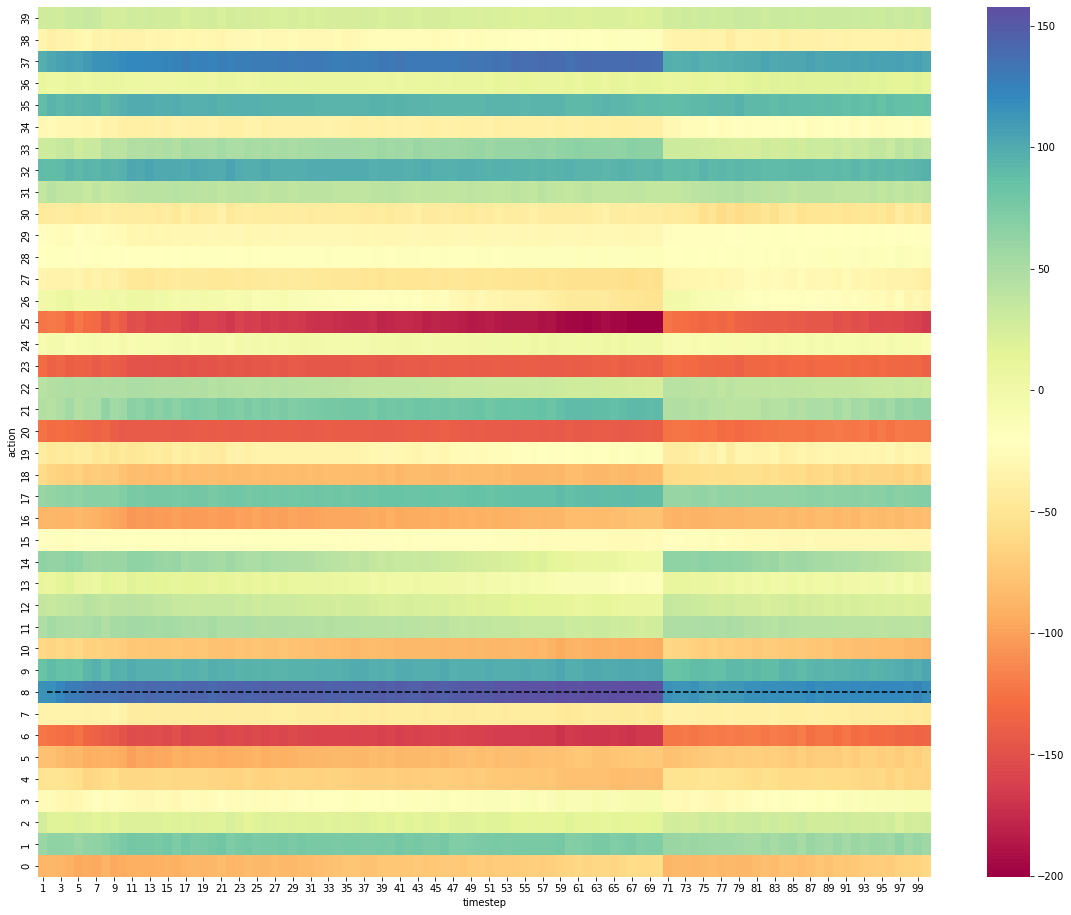

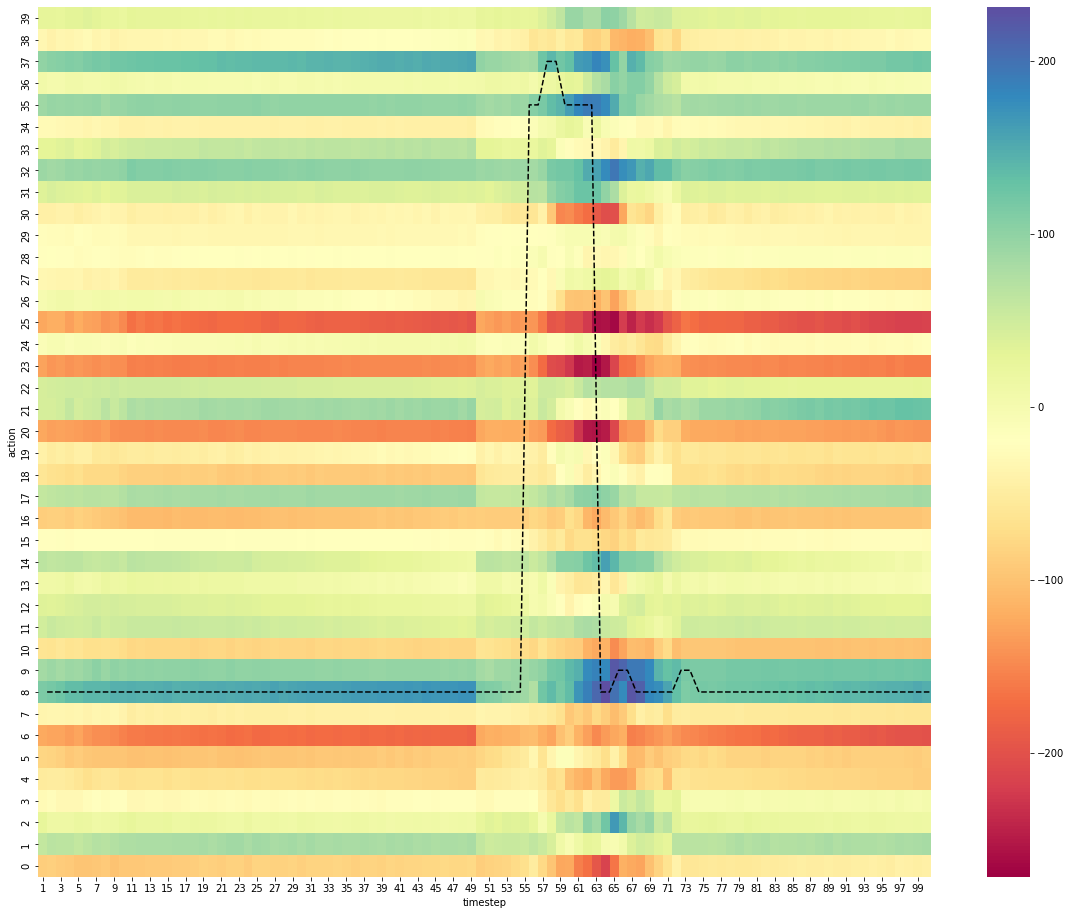

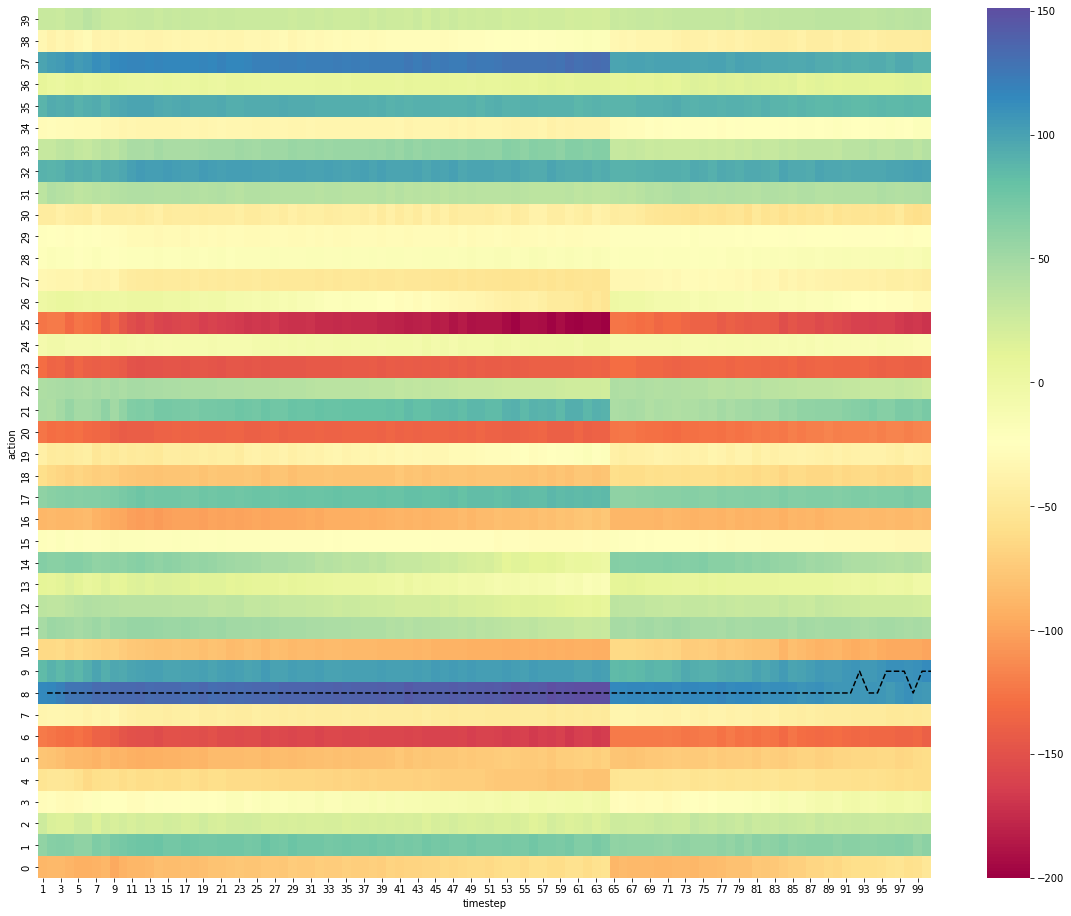

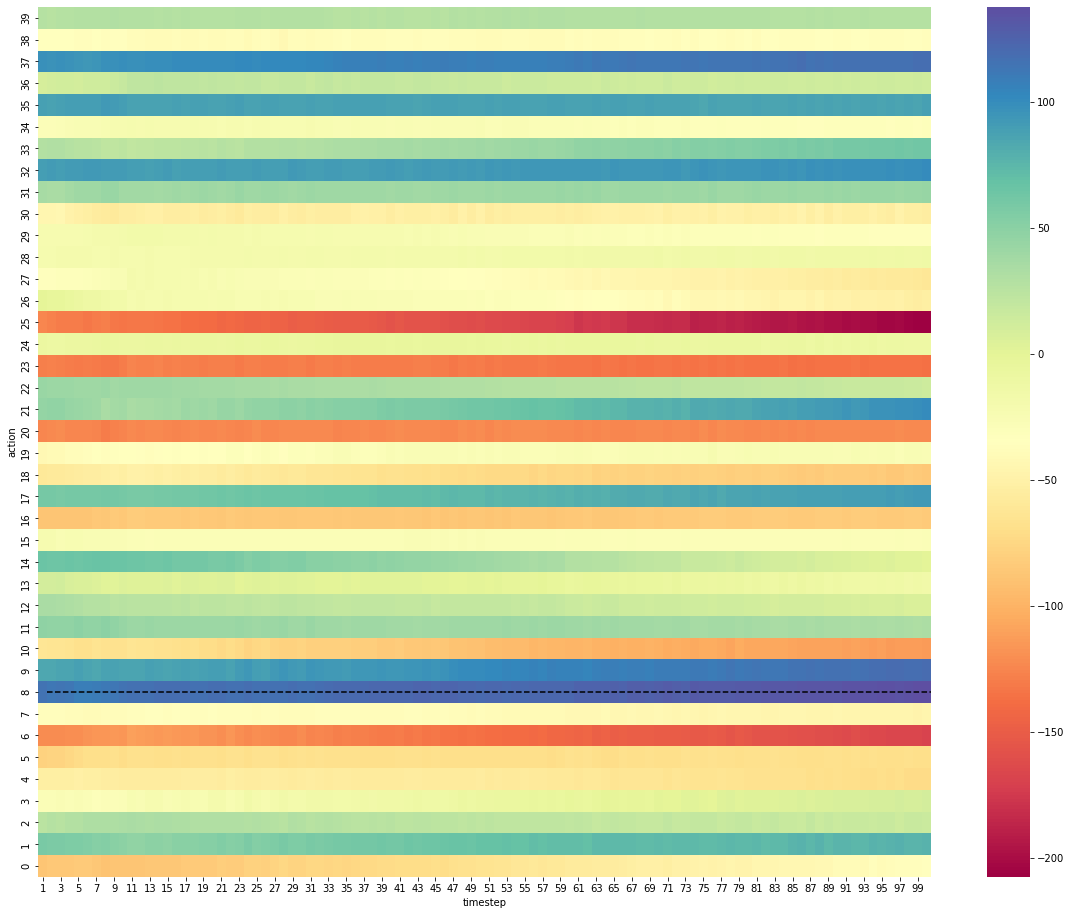

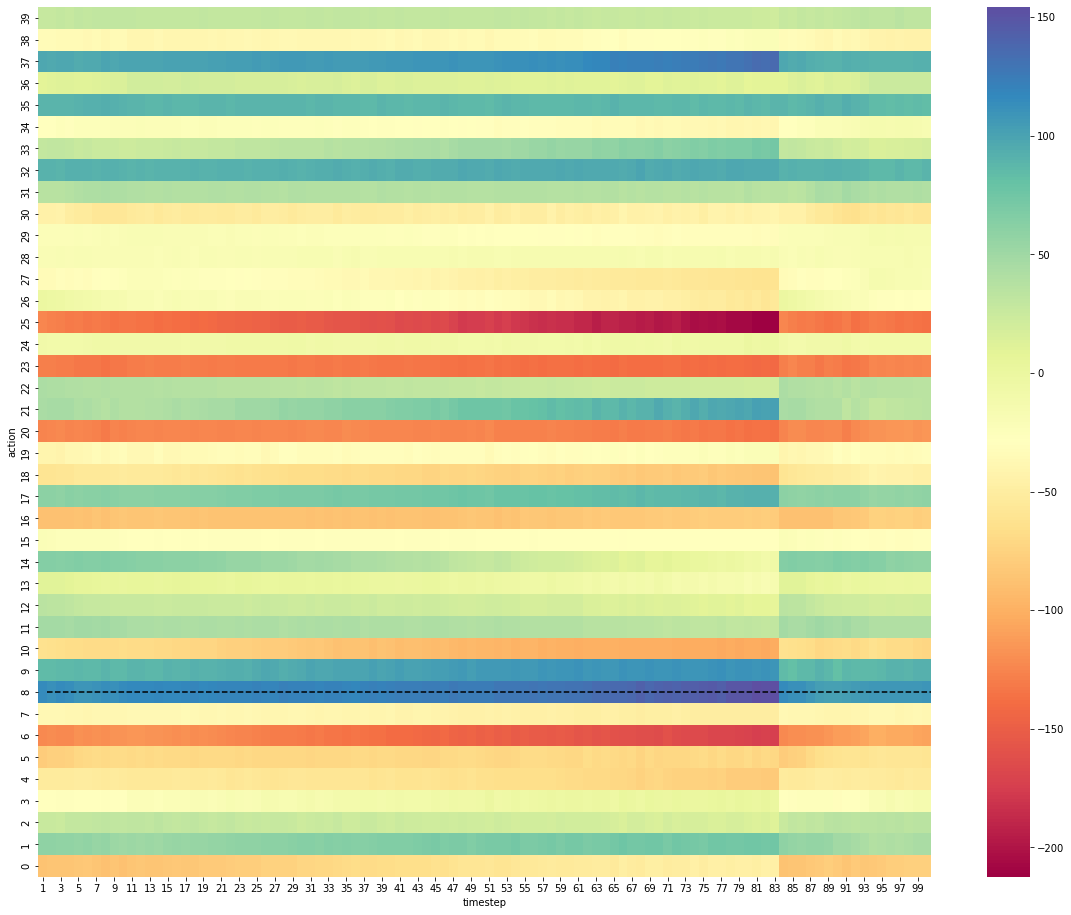

In [20]:
all_train_loss = []
all_metrics = []

run=None

# Plot for untrained model
for i in range(5):
    plot_qlogits_heatmap(qpolicy, eval_env, 0, i, run)

In [21]:
train_agent(1000 * 100, train_policy)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))

Iteration: 0, loss:269.08
Train step counter: 1, epsilon: 1.000
AverageReturn: 0.0

Iteration: 1000, loss:74.11
Train step counter: 1001, epsilon: 1.000
AverageReturn: 4145.1748046875

Iteration: 2000, loss:204.10
Train step counter: 2001, epsilon: 0.999
AverageReturn: 4477.89990234375

Iteration: 3000, loss:65.75
Train step counter: 3001, epsilon: 0.999
AverageReturn: 5434.75

Iteration: 4000, loss:185.66
Train step counter: 4001, epsilon: 0.998
AverageReturn: 5040.5498046875

Iteration: 5000, loss:72.46
Train step counter: 5001, epsilon: 0.998
AverageReturn: 3751.27490234375

Iteration: 6000, loss:234.85
Train step counter: 6001, epsilon: 0.997
AverageReturn: 5440.0498046875

Iteration: 7000, loss:95.91
Train step counter: 7001, epsilon: 0.997
AverageRe


Iteration: 75000, loss:482.57
Train step counter: 75001, epsilon: 0.963
AverageReturn: 4259.10009765625

Iteration: 76000, loss:363.34
Train step counter: 76001, epsilon: 0.962
AverageReturn: 5322.6748046875

Iteration: 77000, loss:155.29
Train step counter: 77001, epsilon: 0.962
AverageReturn: 4278.85009765625

Iteration: 78000, loss:549.78
Train step counter: 78001, epsilon: 0.961
AverageReturn: 3486.449951171875

Iteration: 79000, loss:546.03
Train step counter: 79001, epsilon: 0.961
AverageReturn: 5064.75

Iteration: 80000, loss:698.13
Train step counter: 80001, epsilon: 0.960
AverageReturn: 5056.75

Iteration: 81000, loss:206.25
Train step counter: 81001, epsilon: 0.960
AverageReturn: 4709.75

Iteration: 82000, loss:335.24
Train step counter: 82001, epsilon: 0.959
AverageReturn: 3641.52490234375

Iteration: 83000, loss:398.17
Train step counter: 83001, epsilon: 0.959
AverageReturn: 5295.2001953125

Iteration: 84000, loss:678.58
Train step counter: 84001, epsilon: 0.958
AverageRet

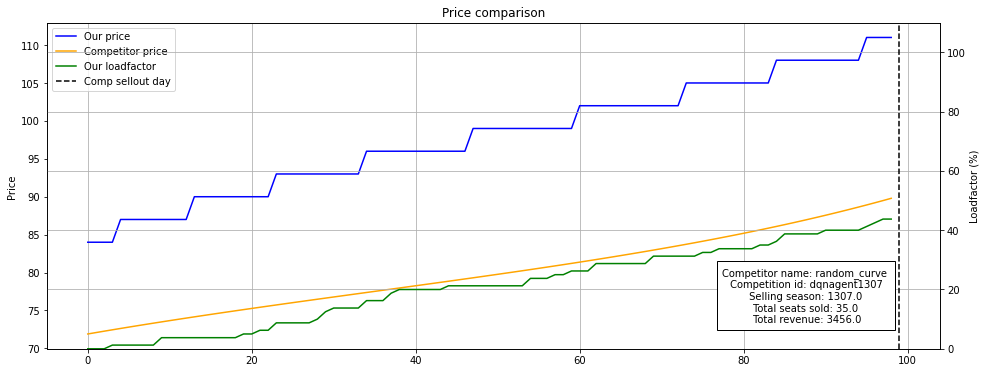

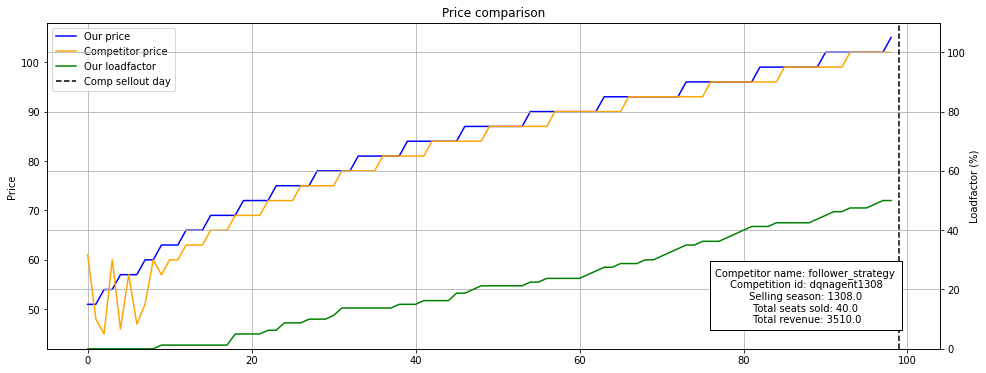

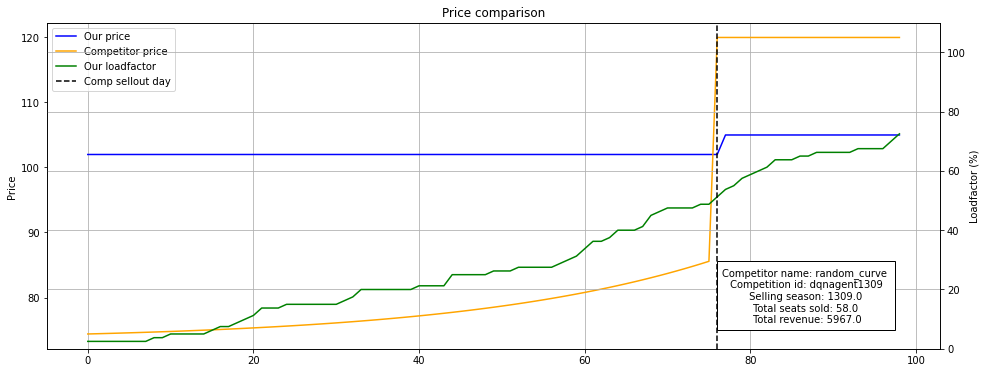

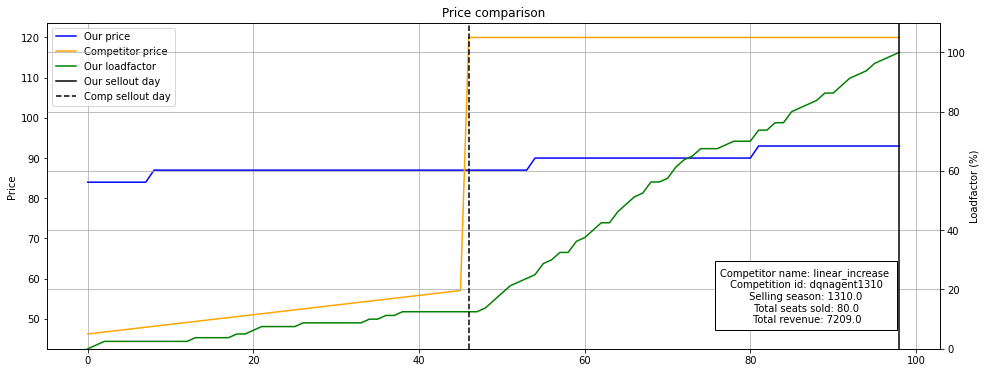

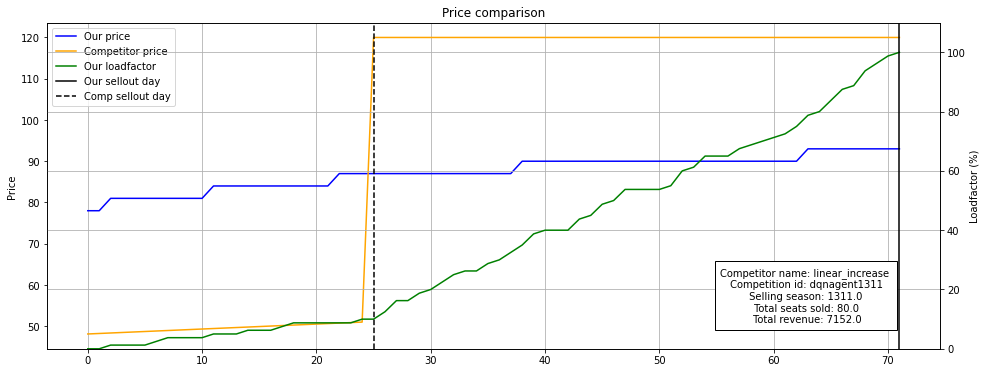

In [22]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'

    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, run)

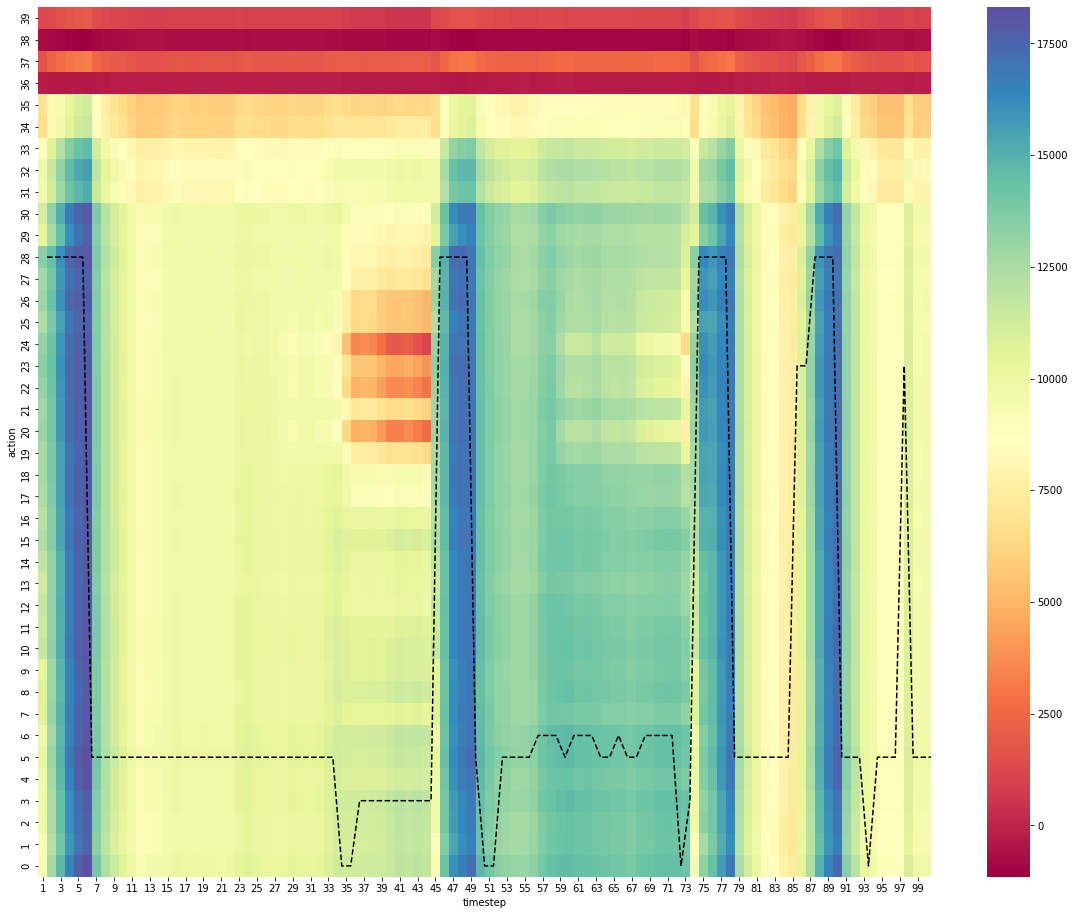

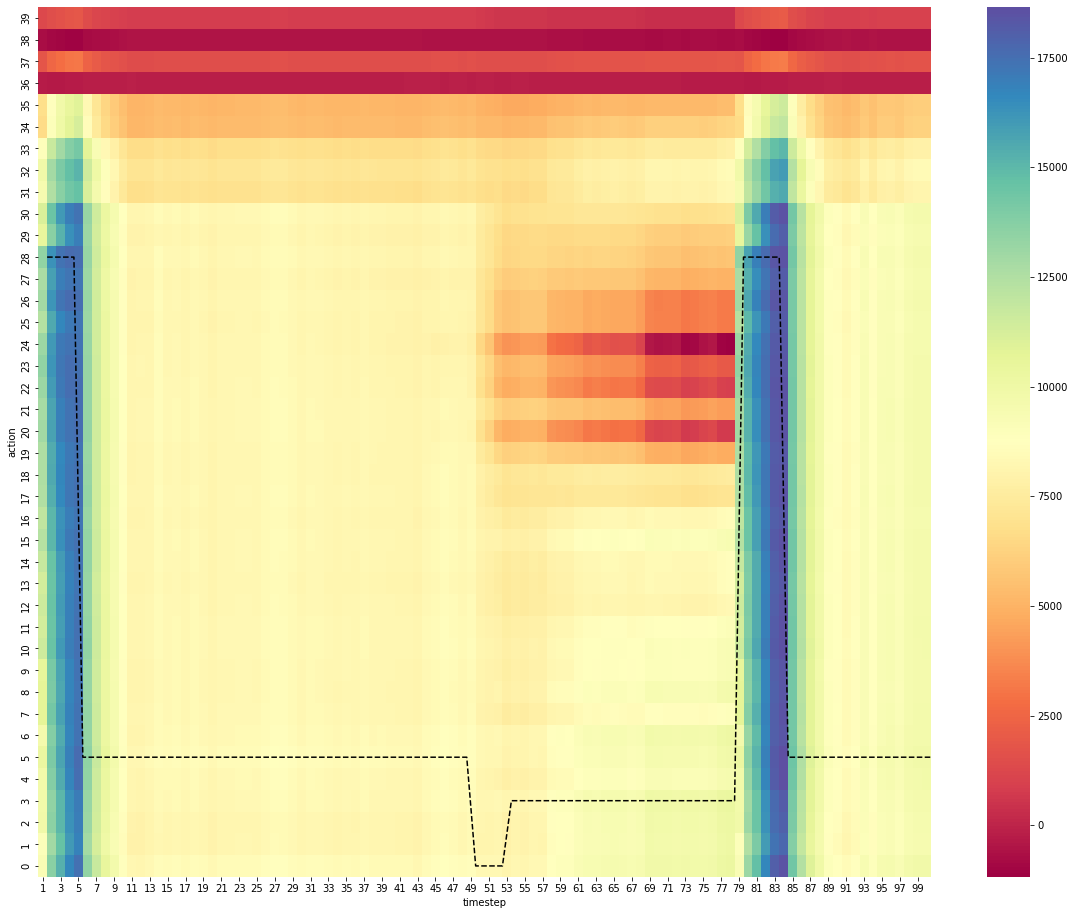

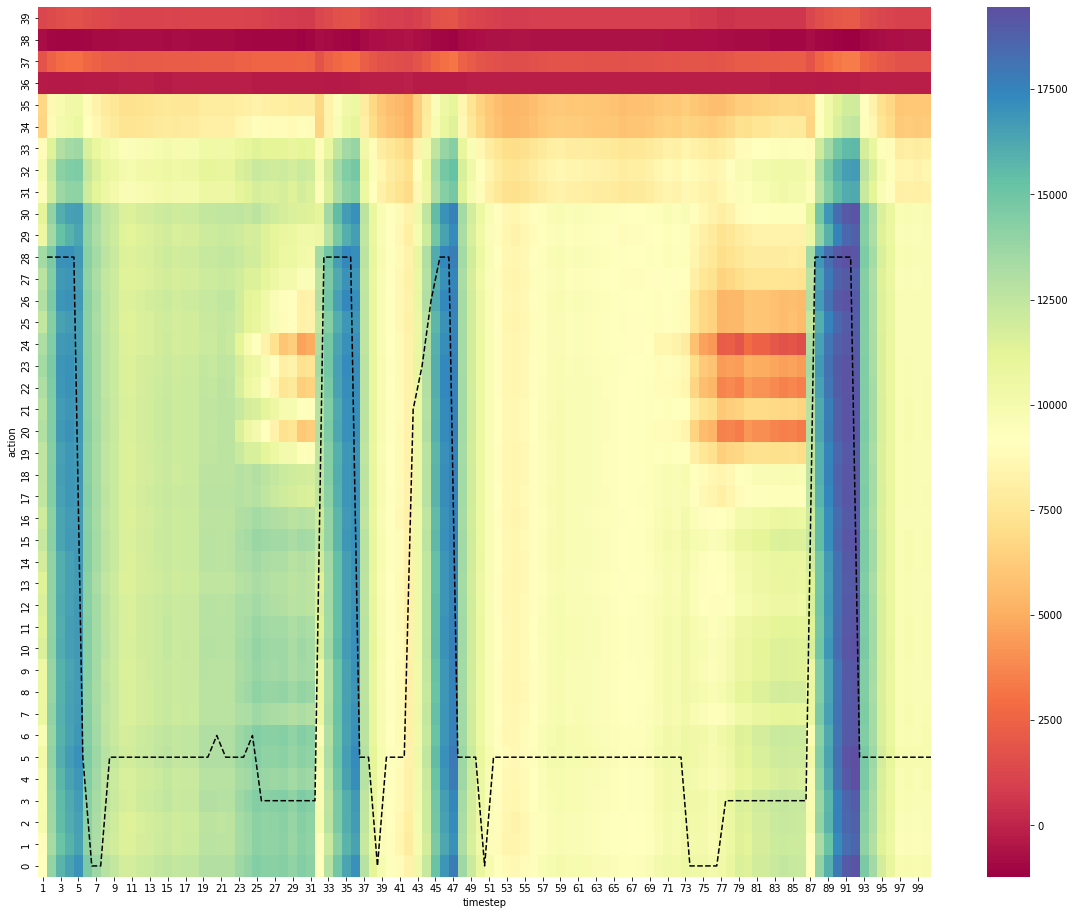

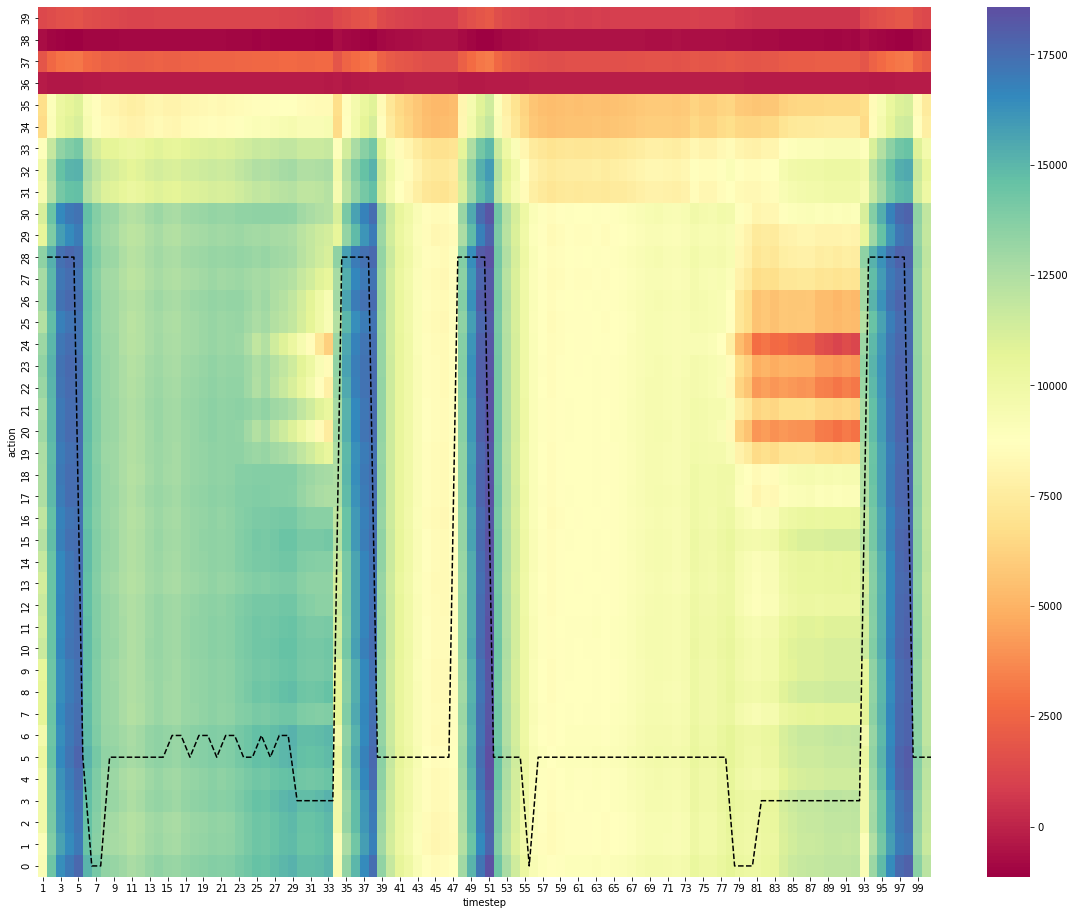

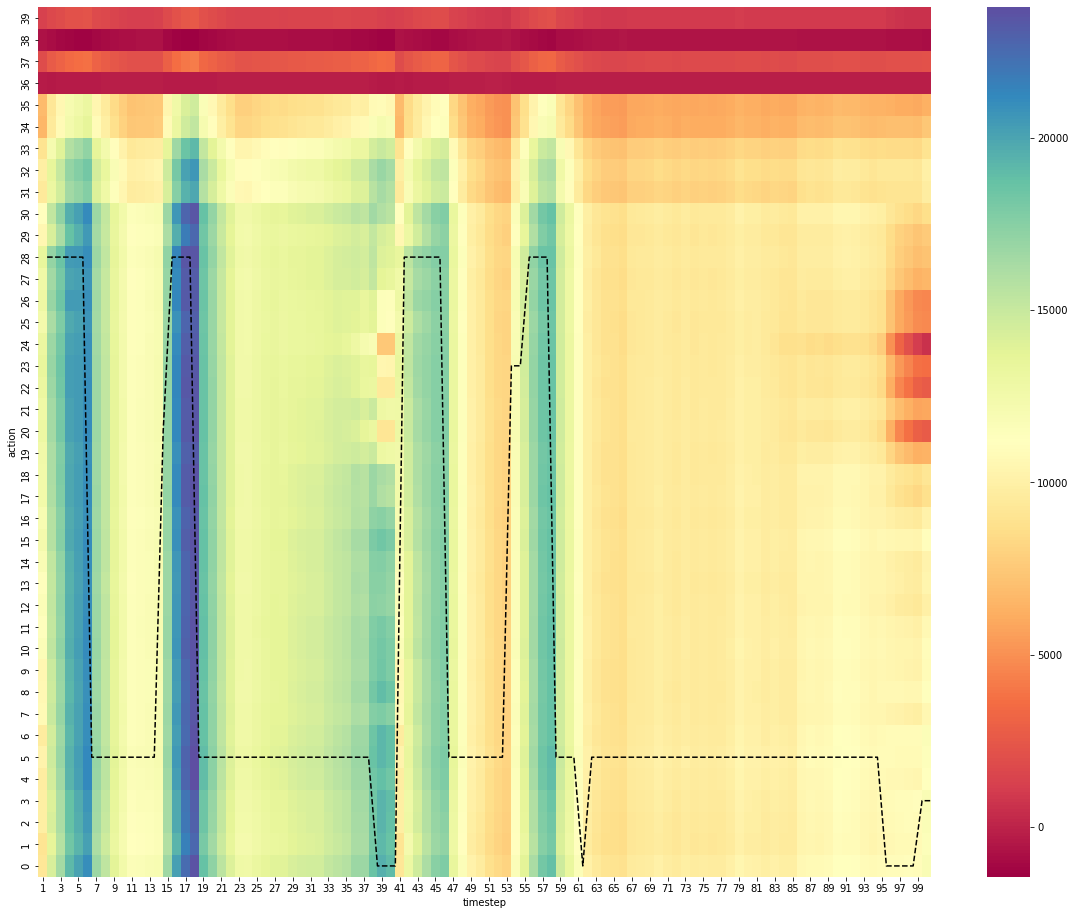

In [23]:
for i in range(5):
        
    plot_qlogits_heatmap(qpolicy, eval_env, i+1, i, run)

In [24]:
train_agent(2000 * 100, train_policy)


Iteration: 0, loss:662.45
Train step counter: 100001, epsilon: 0.950
AverageReturn: 4444.875

Iteration: 1000, loss:837.05
Train step counter: 101001, epsilon: 0.950
AverageReturn: 5260.4501953125

Iteration: 2000, loss:1063.32
Train step counter: 102001, epsilon: 0.950
AverageReturn: 4882.5

Iteration: 3000, loss:497.09
Train step counter: 103001, epsilon: 0.949
AverageReturn: 3878.699951171875

Iteration: 4000, loss:633.97
Train step counter: 104001, epsilon: 0.949
AverageReturn: 4415.52490234375

Iteration: 5000, loss:509.57
Train step counter: 105001, epsilon: 0.948
AverageReturn: 4465.625

Iteration: 6000, loss:1471.92
Train step counter: 106001, epsilon: 0.948
AverageReturn: 5123.39990234375

Iteration: 7000, loss:212.71
Train step counter: 107001, epsilon: 0.947
AverageReturn: 4670.125

Iteration: 8000, loss:1650.05
Train step counter: 108001, epsilon: 0.947
AverageReturn: 4912.75

Iteration: 9000, loss:665.65
Train step counter: 109001, epsilon: 0.946
AverageReturn: 3227.60009


Iteration: 79000, loss:1821.87
Train step counter: 179001, epsilon: 0.911
AverageReturn: 5126.9501953125

Iteration: 80000, loss:3736.64
Train step counter: 180001, epsilon: 0.911
AverageReturn: 5202.02490234375

Iteration: 81000, loss:2781.29
Train step counter: 181001, epsilon: 0.910
AverageReturn: 4164.3251953125

Iteration: 82000, loss:7467.34
Train step counter: 182001, epsilon: 0.910
AverageReturn: 4530.97509765625

Iteration: 83000, loss:4572.77
Train step counter: 183001, epsilon: 0.909
AverageReturn: 5578.85009765625

Iteration: 84000, loss:8200.64
Train step counter: 184001, epsilon: 0.909
AverageReturn: 5227.25

Iteration: 85000, loss:3985.70
Train step counter: 185001, epsilon: 0.908
AverageReturn: 4502.27490234375

Iteration: 86000, loss:4508.53
Train step counter: 186001, epsilon: 0.908
AverageReturn: 4022.60009765625

Iteration: 87000, loss:1837.64
Train step counter: 187001, epsilon: 0.907
AverageReturn: 4284.72509765625

Iteration: 88000, loss:6295.37
Train step count


Iteration: 157000, loss:16703.38
Train step counter: 257001, epsilon: 0.873
AverageReturn: 3715.64990234375

Iteration: 158000, loss:21542.35
Train step counter: 258001, epsilon: 0.872
AverageReturn: 4195.0751953125

Iteration: 159000, loss:13457.63
Train step counter: 259001, epsilon: 0.872
AverageReturn: 3997.10009765625

Iteration: 160000, loss:20243.60
Train step counter: 260001, epsilon: 0.871
AverageReturn: 3545.10009765625

Iteration: 161000, loss:3375.09
Train step counter: 261001, epsilon: 0.871
AverageReturn: 5181.8251953125

Iteration: 162000, loss:33247.10
Train step counter: 262001, epsilon: 0.870
AverageReturn: 4367.72509765625

Iteration: 163000, loss:7030.45
Train step counter: 263001, epsilon: 0.870
AverageReturn: 4711.125

Iteration: 164000, loss:48465.30
Train step counter: 264001, epsilon: 0.869
AverageReturn: 4239.02490234375

Iteration: 165000, loss:10156.17
Train step counter: 265001, epsilon: 0.869
AverageReturn: 5572.375

Iteration: 166000, loss:53677.31
Train

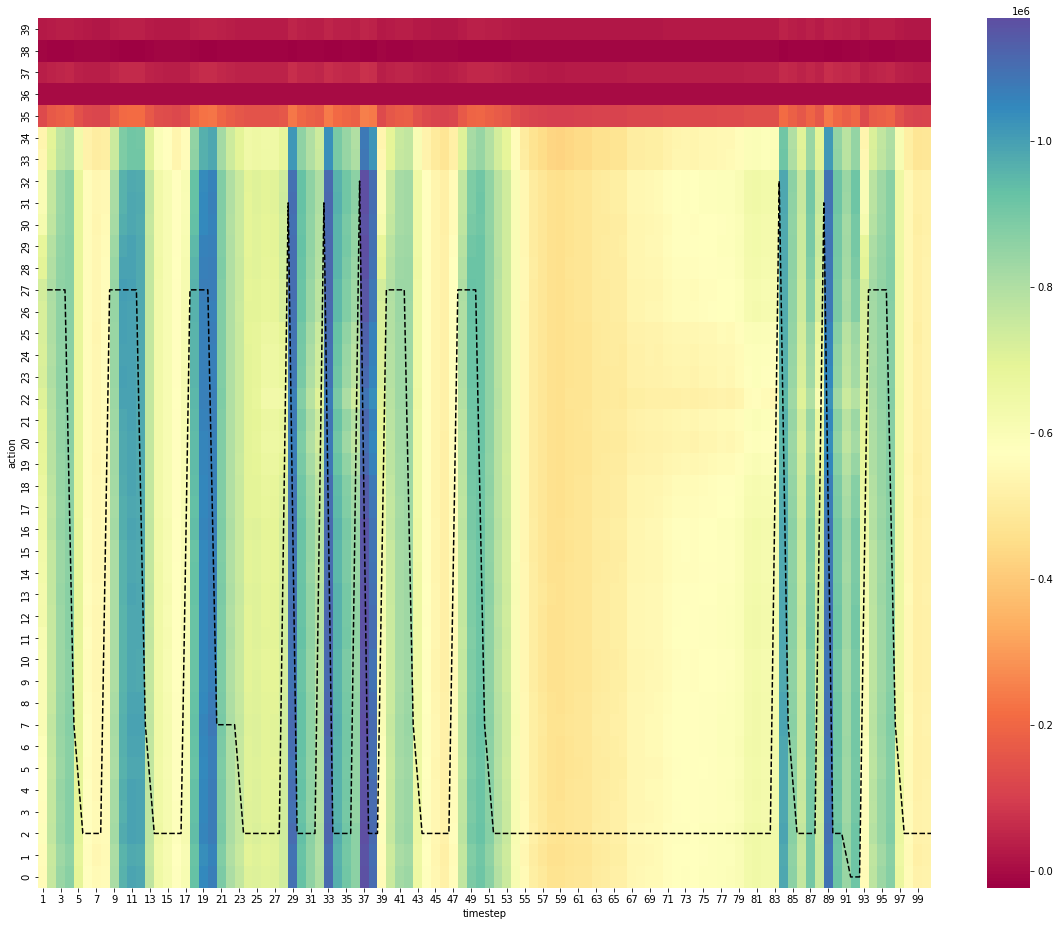

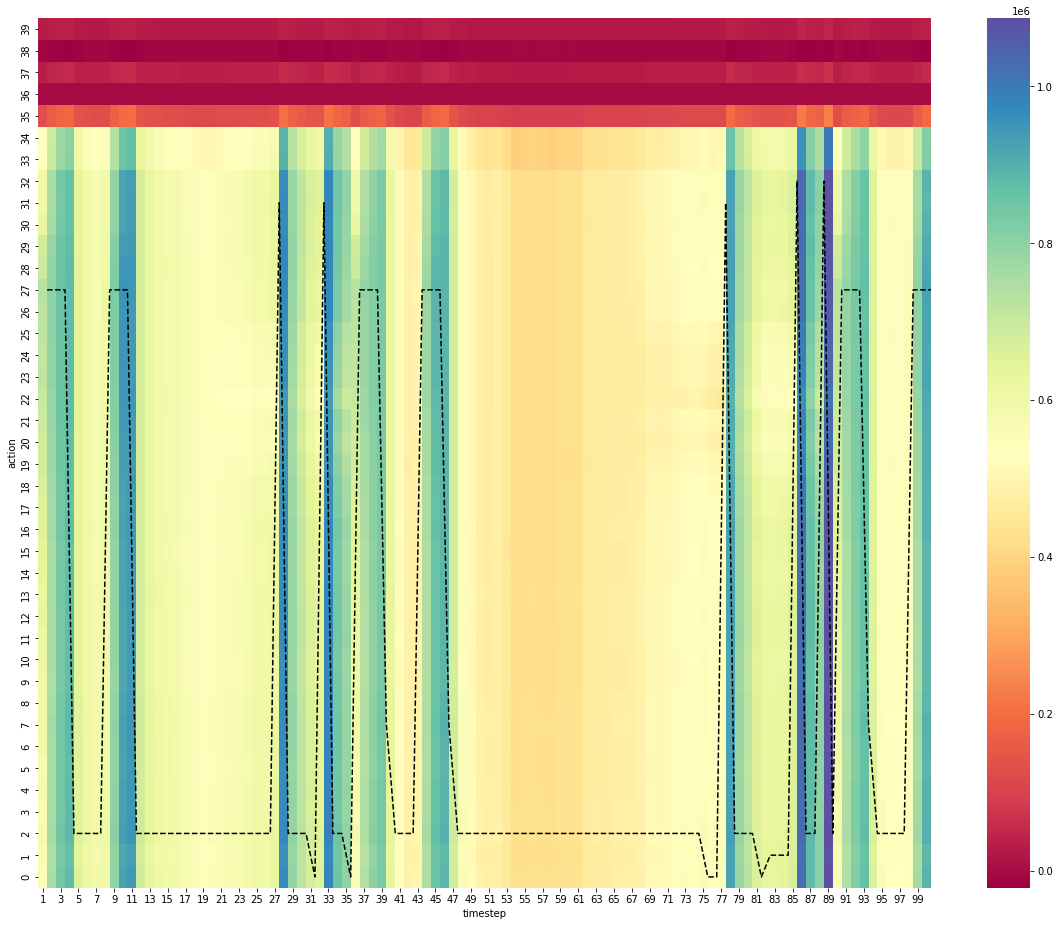

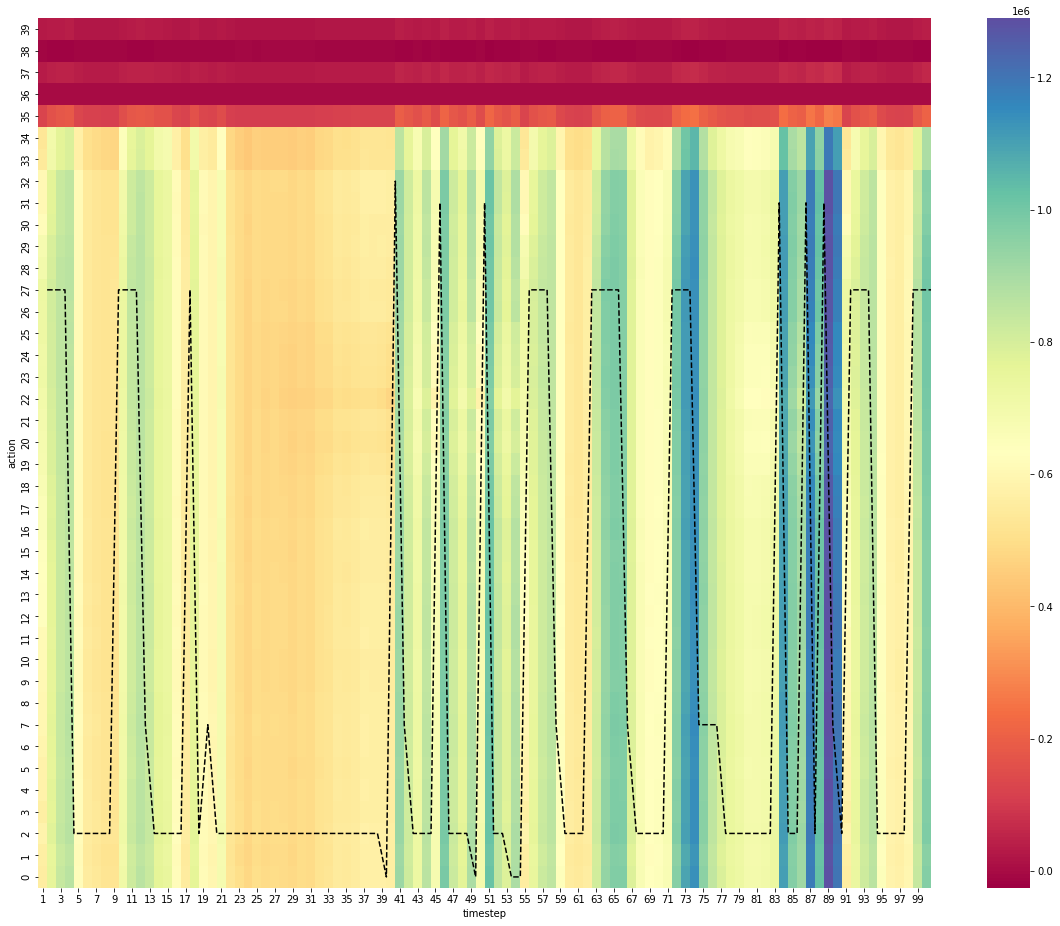

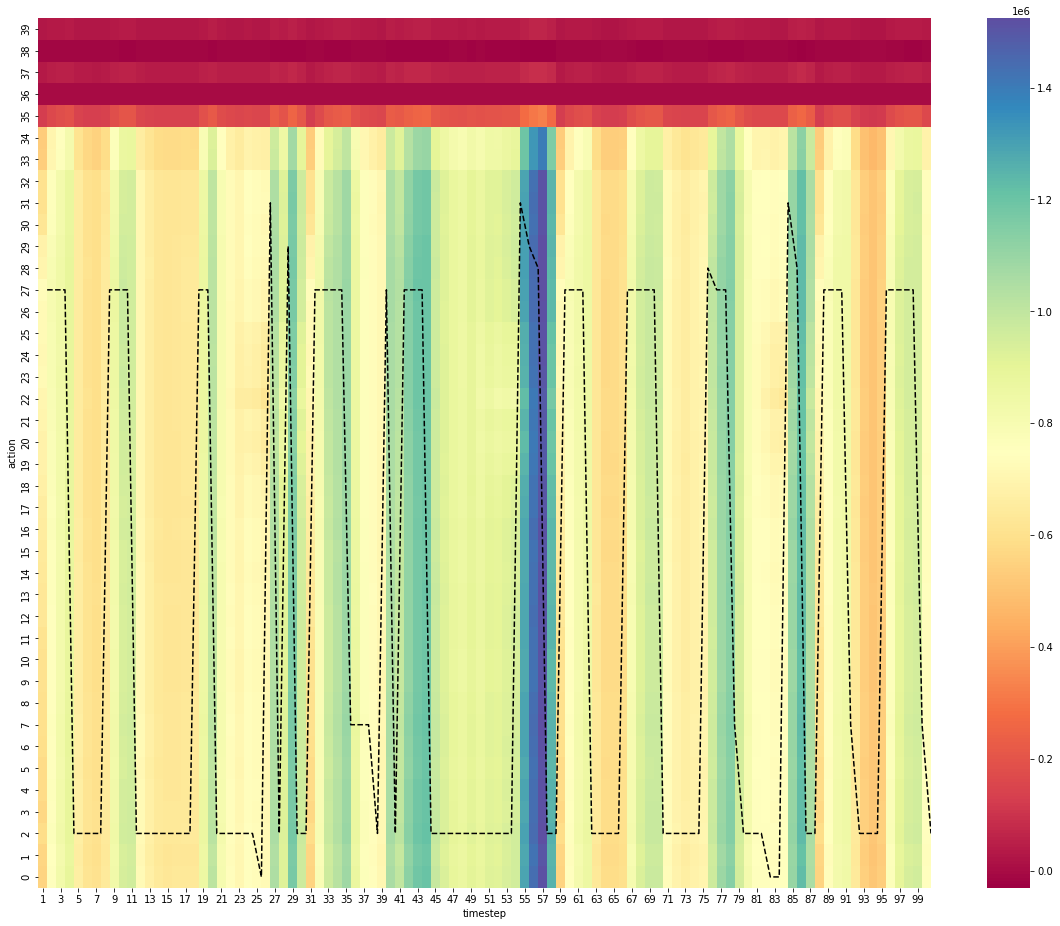

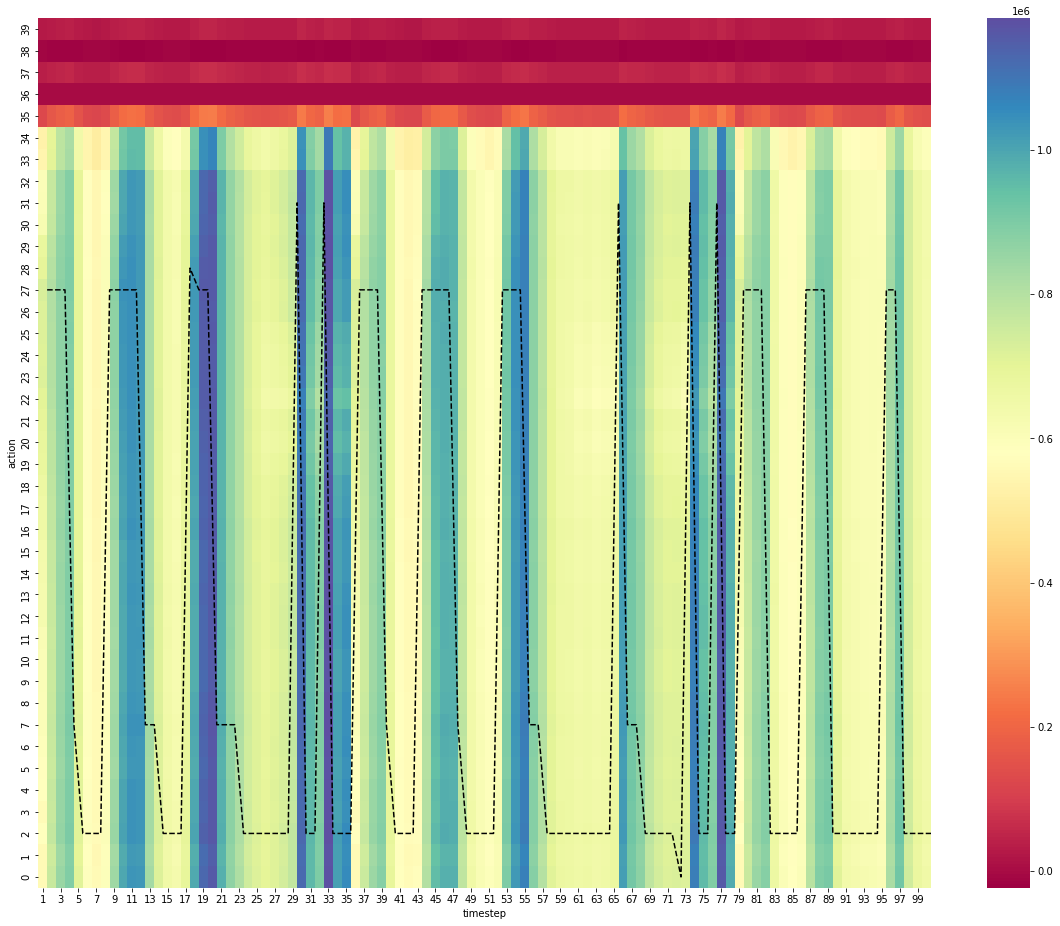

In [25]:
for i in range(5):
        
    plot_qlogits_heatmap(qpolicy, eval_env, i+1, i, run)

In [26]:
train_agent(5000 * 100, train_policy)


Iteration: 0, loss:19539.81
Train step counter: 300001, epsilon: 0.851
AverageReturn: 4706.5

Iteration: 1000, loss:30212.62
Train step counter: 301001, epsilon: 0.851
AverageReturn: 4196.47509765625

Iteration: 2000, loss:56709.17
Train step counter: 302001, epsilon: 0.851
AverageReturn: 4417.25

Iteration: 3000, loss:6782.30
Train step counter: 303001, epsilon: 0.850
AverageReturn: 2856.64990234375

Iteration: 4000, loss:39209.12
Train step counter: 304001, epsilon: 0.850
AverageReturn: 4407.14990234375

Iteration: 5000, loss:10053.93
Train step counter: 305001, epsilon: 0.849
AverageReturn: 4674.5498046875

Iteration: 6000, loss:35434.26
Train step counter: 306001, epsilon: 0.849
AverageReturn: 4958.125

Iteration: 7000, loss:35721.58
Train step counter: 307001, epsilon: 0.848
AverageReturn: 4933.7998046875

Iteration: 8000, loss:34327.98
Train step counter: 308001, epsilon: 0.848
AverageReturn: 4514.22509765625

Iteration: 9000, loss:11061.59
Train step counter: 309001, epsilon: 0


Iteration: 78000, loss:142219.50
Train step counter: 378001, epsilon: 0.813
AverageReturn: 3829.324951171875

Iteration: 79000, loss:86342.85
Train step counter: 379001, epsilon: 0.812
AverageReturn: 5289.0

Iteration: 80000, loss:87318.16
Train step counter: 380001, epsilon: 0.812
AverageReturn: 5055.10009765625

Iteration: 81000, loss:99093.50
Train step counter: 381001, epsilon: 0.811
AverageReturn: 3971.175048828125

Iteration: 82000, loss:99276.28
Train step counter: 382001, epsilon: 0.811
AverageReturn: 4261.1748046875

Iteration: 83000, loss:22112.54
Train step counter: 383001, epsilon: 0.810
AverageReturn: 3337.97509765625

Iteration: 84000, loss:116004.78
Train step counter: 384001, epsilon: 0.810
AverageReturn: 4509.25

Iteration: 85000, loss:19256.77
Train step counter: 385001, epsilon: 0.809
AverageReturn: 4280.60009765625

Iteration: 86000, loss:139288.61
Train step counter: 386001, epsilon: 0.809
AverageReturn: 5649.2001953125

Iteration: 87000, loss:15645.03
Train step 


Iteration: 154000, loss:238385.14
Train step counter: 454001, epsilon: 0.775
AverageReturn: 5487.7998046875

Iteration: 155000, loss:44052.88
Train step counter: 455001, epsilon: 0.775
AverageReturn: 4850.35009765625

Iteration: 156000, loss:624486.00
Train step counter: 456001, epsilon: 0.774
AverageReturn: 4847.97509765625

Iteration: 157000, loss:292039.41
Train step counter: 457001, epsilon: 0.774
AverageReturn: 4585.2001953125

Iteration: 158000, loss:1065620.62
Train step counter: 458001, epsilon: 0.773
AverageReturn: 3965.449951171875

Iteration: 159000, loss:404667.34
Train step counter: 459001, epsilon: 0.773
AverageReturn: 4092.125

Iteration: 160000, loss:428603.56
Train step counter: 460001, epsilon: 0.772
AverageReturn: 4412.2998046875

Iteration: 161000, loss:68479.38
Train step counter: 461001, epsilon: 0.772
AverageReturn: 5019.27490234375

Iteration: 162000, loss:768104.88
Train step counter: 462001, epsilon: 0.771
AverageReturn: 4646.0751953125

Iteration: 163000, lo


Iteration: 230000, loss:1004512.44
Train step counter: 530001, epsilon: 0.738
AverageReturn: 4070.675048828125

Iteration: 231000, loss:253675.50
Train step counter: 531001, epsilon: 0.737
AverageReturn: 4941.2998046875

Iteration: 232000, loss:861070.06
Train step counter: 532001, epsilon: 0.737
AverageReturn: 4582.2998046875

Iteration: 233000, loss:160499.91
Train step counter: 533001, epsilon: 0.736
AverageReturn: 3914.60009765625

Iteration: 234000, loss:1221479.12
Train step counter: 534001, epsilon: 0.736
AverageReturn: 3915.449951171875

Iteration: 235000, loss:612211.94
Train step counter: 535001, epsilon: 0.735
AverageReturn: 4473.27490234375

Iteration: 236000, loss:1279402.00
Train step counter: 536001, epsilon: 0.735
AverageReturn: 4322.0751953125

Iteration: 237000, loss:1130149.25
Train step counter: 537001, epsilon: 0.734
AverageReturn: 4438.5

Iteration: 238000, loss:401585.12
Train step counter: 538001, epsilon: 0.734
AverageReturn: 3383.449951171875

Iteration: 2390


Iteration: 306000, loss:2009690.25
Train step counter: 606001, epsilon: 0.700
AverageReturn: 4464.10009765625

Iteration: 307000, loss:2089515.25
Train step counter: 607001, epsilon: 0.700
AverageReturn: 4897.25

Iteration: 308000, loss:5040636.00
Train step counter: 608001, epsilon: 0.699
AverageReturn: 4782.9248046875

Iteration: 309000, loss:3018972.00
Train step counter: 609001, epsilon: 0.699
AverageReturn: 5026.5

Iteration: 310000, loss:2927723.75
Train step counter: 610001, epsilon: 0.698
AverageReturn: 4493.0751953125

Iteration: 311000, loss:1756056.38
Train step counter: 611001, epsilon: 0.698
AverageReturn: 5091.60009765625

Iteration: 312000, loss:1217947.12
Train step counter: 612001, epsilon: 0.697
AverageReturn: 4148.4248046875

Iteration: 313000, loss:282142.38
Train step counter: 613001, epsilon: 0.697
AverageReturn: 4844.60009765625

Iteration: 314000, loss:1571500.50
Train step counter: 614001, epsilon: 0.696
AverageReturn: 3985.574951171875

Iteration: 315000, los


Iteration: 382000, loss:5511959.50
Train step counter: 682001, epsilon: 0.662
AverageReturn: 4771.125

Iteration: 383000, loss:885609.94
Train step counter: 683001, epsilon: 0.662
AverageReturn: 4152.22509765625

Iteration: 384000, loss:6433357.00
Train step counter: 684001, epsilon: 0.661
AverageReturn: 4689.1748046875

Iteration: 385000, loss:771740.25
Train step counter: 685001, epsilon: 0.661
AverageReturn: 4213.14990234375

Iteration: 386000, loss:2603437.75
Train step counter: 686001, epsilon: 0.660
AverageReturn: 4655.375

Iteration: 387000, loss:1442131.25
Train step counter: 687001, epsilon: 0.660
AverageReturn: 4951.8251953125

Iteration: 388000, loss:5281541.50
Train step counter: 688001, epsilon: 0.659
AverageReturn: 4644.0751953125

Iteration: 389000, loss:2728943.75
Train step counter: 689001, epsilon: 0.659
AverageReturn: 4711.7998046875

Iteration: 390000, loss:5710051.50
Train step counter: 690001, epsilon: 0.658
AverageReturn: 5192.25

Iteration: 391000, loss:4406192


Iteration: 458000, loss:6378391.50
Train step counter: 758001, epsilon: 0.625
AverageReturn: 3432.85009765625

Iteration: 459000, loss:16278523.00
Train step counter: 759001, epsilon: 0.624
AverageReturn: 4395.625

Iteration: 460000, loss:8241400.00
Train step counter: 760001, epsilon: 0.624
AverageReturn: 3800.35009765625

Iteration: 461000, loss:5216384.00
Train step counter: 761001, epsilon: 0.623
AverageReturn: 5478.9501953125

Iteration: 462000, loss:9919016.00
Train step counter: 762001, epsilon: 0.623
AverageReturn: 4078.0

Iteration: 463000, loss:9632266.00
Train step counter: 763001, epsilon: 0.622
AverageReturn: 4593.0751953125

Iteration: 464000, loss:19117468.00
Train step counter: 764001, epsilon: 0.622
AverageReturn: 3842.925048828125

Iteration: 465000, loss:1081872.00
Train step counter: 765001, epsilon: 0.621
AverageReturn: 4521.5751953125

Iteration: 466000, loss:8976888.00
Train step counter: 766001, epsilon: 0.621
AverageReturn: 3844.52490234375

Iteration: 467000,

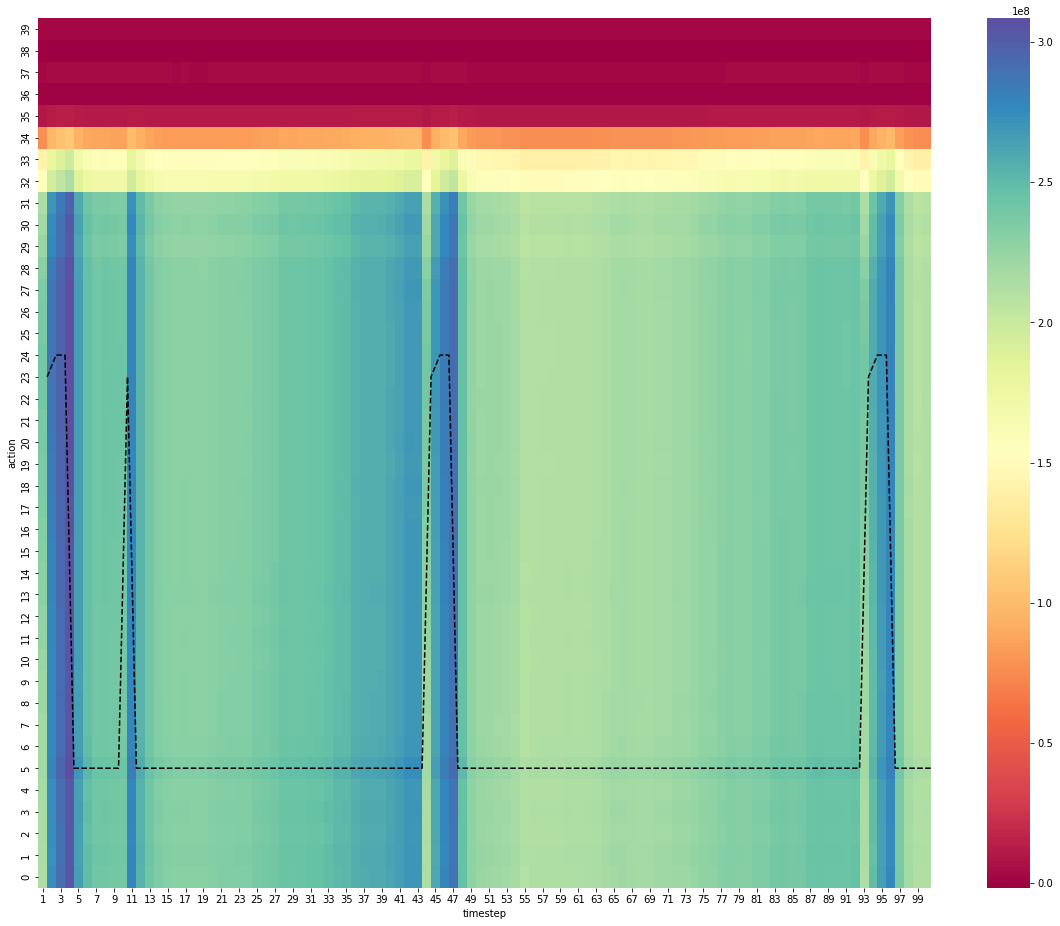

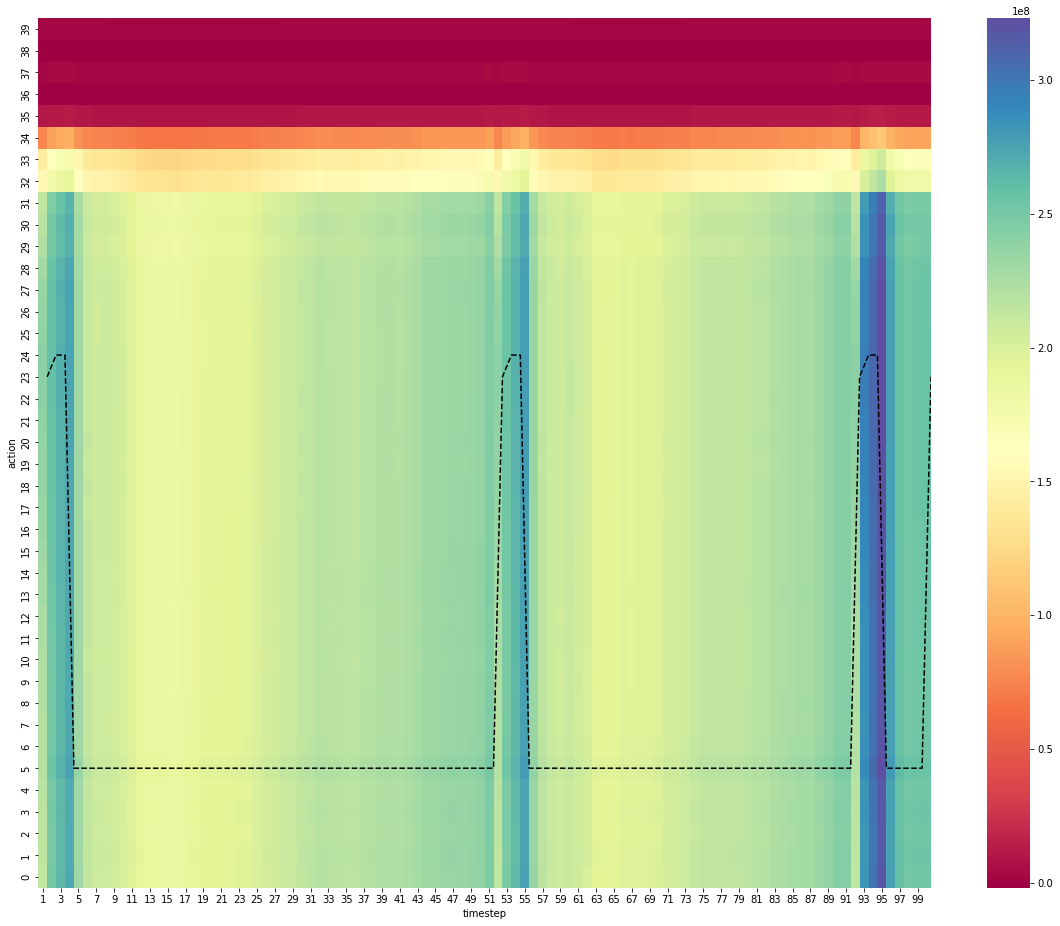

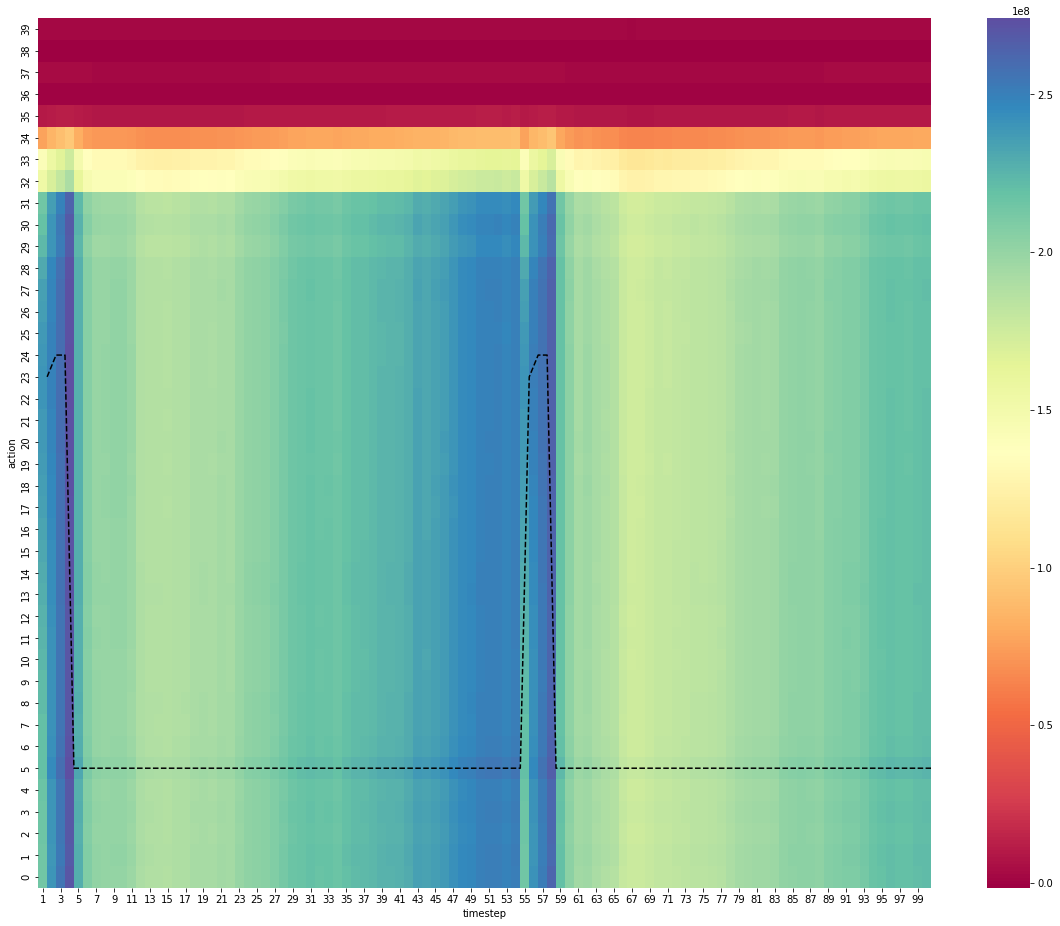

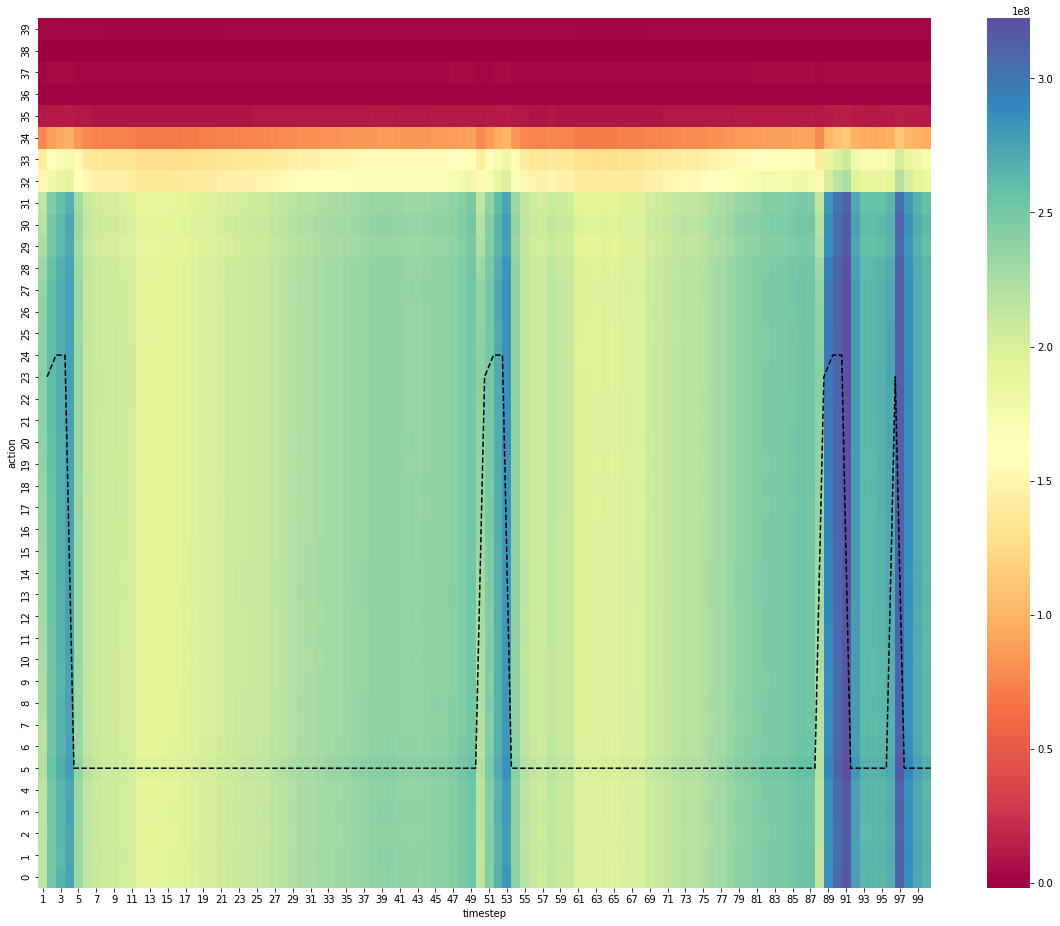

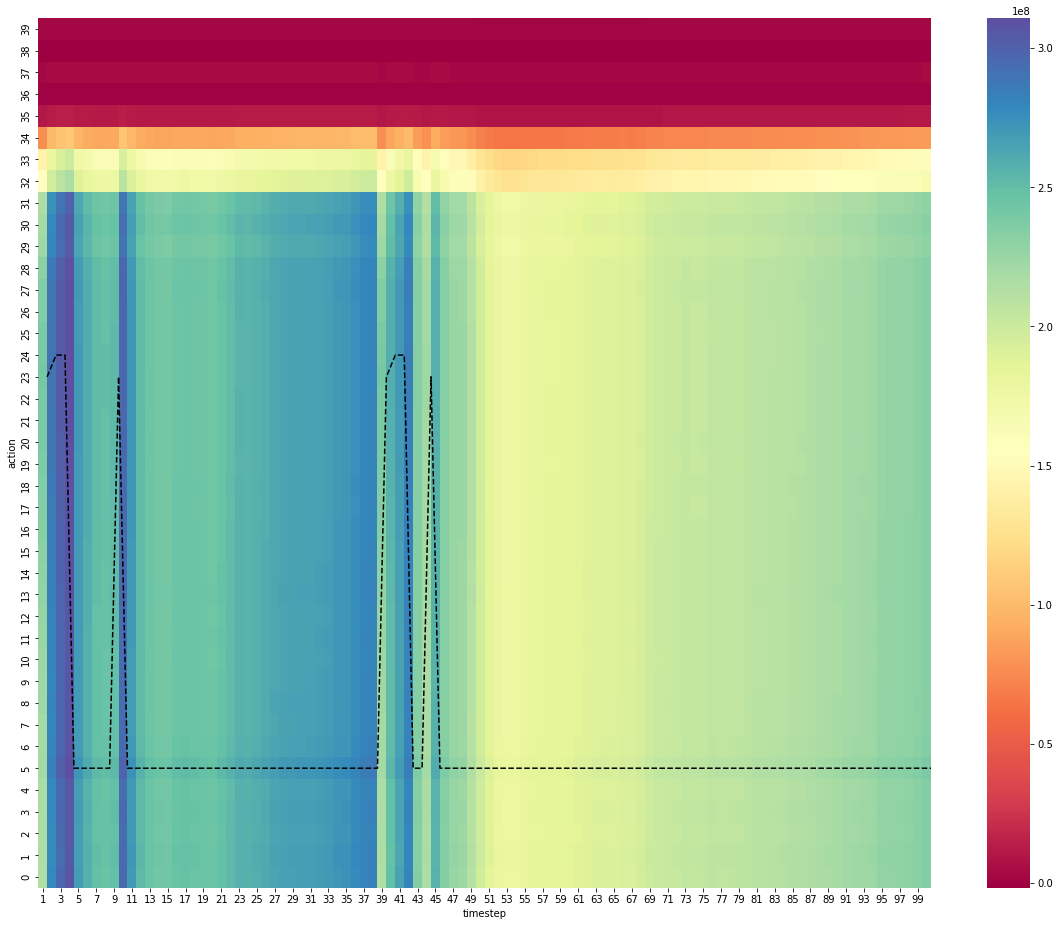

In [27]:
for i in range(5):
        
    plot_qlogits_heatmap(qpolicy, eval_env, i+1, i, run)

In [28]:
train_agent(5000 * 100, train_policy)


Iteration: 0, loss:14731466.00
Train step counter: 800001, epsilon: 0.604
AverageReturn: 4937.89990234375


KeyboardInterrupt: 

In [ ]:
for i in range(5):
        
    plot_qlogits_heatmap(qpolicy, eval_env, i+1, i, run)